In [1]:
import requests
import tempfile
import json
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import itertools
from pprint import pprint
import geopandas as gpd
import re

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

## 1. Fetching data
API information can be found [here](https://data.nsw.gov.au/data/api/1/util/snippet/api_info.html?resource_id=530d86bc-cdc3-4e3f-b828-5106cd0e48c3)

**data.nsw** is a [CKAN](https://docs.ckan.org/en/2.9/user-guide.html#what-is-ckan) data website

A list of **GET-able API functions** can be found [here](https://docs.ckan.org/en/2.9/api/index.html#get-able-api-functions)

[Glossary:](https://data.nsw.gov.au/data/dataset/297dfb0e-3b94-433b-be64-3bb0905e28a4/resource/2690ceb9-1701-4f50-99db-dc9a4ff3c4d1/download/ebethanyglossary.xlsx)
<br clear='all' />
<a href='https://data.nsw.gov.au/data/dataset/297dfb0e-3b94-433b-be64-3bb0905e28a4/resource/2690ceb9-1701-4f50-99db-dc9a4ff3c4d1/download/ebethanyglossary.xlsx'>
    <img src='glossary.png' align='left'>
</a>
<br clear='all' />
<br></br>
More information about [Gaming Machine Entitlements](https://www.liquorandgaming.nsw.gov.au/operating-a-business/gaming-licences/gaming-licences-permits/hotel-and-club-gaming-licences)
<br clear='all' />
<br></br>
More information about column **Band**, as it's missing in the glossary:
<br clear='all' />
<a href='https://www.liquorandgaming.nsw.gov.au/documents/fs/fs3138-local-impact-assessment-scheme-overview.pdf'>
    <img src='LIA bands (resized).png' align='left'>
</a>
<br clear='all' />

### 1.1 Using CKAN API function [**resource_show**](https://docs.ckan.org/en/2.9/api/index.html#ckan.logic.action.get.resource_show) to get URL of CSV file

In [3]:
url = 'https://data.nsw.gov.au/data/api/3/action/'

In [4]:
data_set_id = '530d86bc-cdc3-4e3f-b828-5106cd0e48c3'

In [5]:
url_full = url + 'resource_show?' + f'id={data_set_id}'

In [6]:
with requests.session() as s:
    respose = s.get(url_full)

In [7]:
if respose.status_code != 200 or not respose.json()['success']:
    raise RuntimeError(f'Something went wrong while querying url:\n{url_full}\nPlease try again later!')

In [8]:
pprint(respose.json())

{'help': 'https://data.nsw.gov.au/data/api/3/action/help_show?name=resource_show',
 'result': {'cache_last_updated': None,
            'cache_url': None,
            'ckan_url': 'https://data.nsw.gov.au',
            'created': '2021-02-09T10:14:40.437049',
            'datastore_active': True,
            'datastore_contains_all_records_of_source_file': True,
            'description': 'Liquor licence premise list as at 8 Feb 2021',
            'format': 'CSV',
            'hash': '',
            'id': '530d86bc-cdc3-4e3f-b828-5106cd0e48c3',
            'ignore_hash': False,
            'last_modified': '2021-02-09T10:14:40.396774',
            'metadata_modified': '2021-02-09T10:14:40.765518',
            'mimetype': 'text/csv',
            'mimetype_inner': None,
            'name': 'Premises list (as at 8 February 2021)',
            'original_url': 'https://data.nsw.gov.au/data/dataset/f4e5fd07-eb6a-420c-a857-6eda213ba6a3/resource/530d86bc-cdc3-4e3f-b828-5106cd0e48c3/download/prem

In [9]:
url_csv = respose.json()['result']['url']

### 1.2 Downloading CSV file

In [10]:
home_dir = os.environ.get('USERPROFILE', None)

In [11]:
temp_file_name = 'temp.csv'

In [12]:
if home_dir:
    csv_file_path = os.path.join(home_dir, 'Downloads')
    if not os.path.exists(csv_file_path):
        raise RuntimeError('"Downloads" folder in your home directory is not found!')
    csv_file_path = os.path.join(csv_file_path, temp_file_name)
else:
    csv_file_path = os.path.join(tempfile.gettempdir(), temp_file_name)

In [13]:
csv_file_path

'C:\\Users\\Shaun Wang\\Downloads\\temp.csv'

Taking a bit of time to make the code for downloading file more robust so that it can be used for downloading large datasets in the future

In [14]:
chunk_size = 1024 * 100

In [15]:
# I love progress bars
with requests.session() as s:
    response = s.get(url_csv, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(csv_file_path, 'wb') as file, tqdm(desc='Downloading data', total=total_size, unit='iB', unit_scale=True) as bar:
        for chunk in response.iter_content(chunk_size=chunk_size):
            size = file.write(chunk)
            bar.update(size)

## 2. EDA - exploratory data analysis

### 2.1 Reading data into dataframe

In [16]:
df1 = pd.read_csv(csv_file_path, encoding='latin', dtype=str)

In [17]:
df1.head()

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
0,LIQC300200019,Liquor - club licence,Current,29/05/1981,Trading,Charlestown Golf Club Ltd,1A Barker Ave,HILLSBOROUGH,2290,-32.9636330000,151.6698160000,Lake Macquarie City Council,NaN,CHARLESTOWN GOLF CLUB LTD,NaN,"Non-restricted area authorisation,Right to keep gaming machines,Unrestricted on premises hours",No,No,No,Yes,Yes,Yes,Yes,Yes,Glendale - Cardiff - Hillsborough,2,11,0,11,0,11,11
1,LIQC300200035,Liquor - club licence,Current,21/08/1981,Trading,Barooga Sports Club Ltd,12 Burkinshaw St,BAROOGA,3644,-35.9064500000,145.6868290000,Berrigan Shire Council,NaN,BAROOGA SPORTS CLUB LTD,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,Tocumwal - Finley - Jerilderie,3,174,0,174,0,174,174
2,LIQC300200078,Liquor - club licence,Current,03/12/1981,Trading,Maclean-Lower Clarence Services Club Ltd,36-38 River St,MACLEAN,2463,-29.4573230000,153.1962430000,Clarence Valley Council,NaN,MACLEAN-LOWER CLARENCE SERVICES CLUB LTD,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,Maclean - Yamba - Iluka,3,34,0,34,0,34,0
3,LIQC300200086,Liquor - club licence,Current,23/12/1981,Trading,Sporties Tuncurry,Beach St,TUNCURRY,2428,-32.1663170000,152.5016900000,Mid-Coast Council,NaN,FORSTER-TUNCURRY MEMORIAL SERVICES CLUB LTD,NaN,"Non-restricted area authorisation,Right to keep gaming machines,Unrestricted on premises hours",No,No,No,Yes,Yes,Yes,Yes,Yes,Tuncurry,3,46,0,46,0,46,46
4,LIQC300200094,Liquor - club licence,Current,15/03/1982,Trading,Canley Heights R S L & Sporting Club Ltd,26 Humphries Rd,WAKELEY,2176,-33.8788750000,150.9128610000,Fairfield City Council,NaN,CANLEY HEIGHTS R S L & SPORTING CLUB LTD,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,St Johns Park - Wakeley,3,150,0,150,0,150,150


### 2.2 Checking for empty rows

In [18]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19304 entries, 0 to 19303
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Licence number                  18747 non-null  object
 1   Licence type                    18747 non-null  object
 2   Status                          18747 non-null  object
 3   Start date                      18747 non-null  object
 4   Trading Status                  18747 non-null  object
 5   Licence name                    18747 non-null  object
 6   Address                         18595 non-null  object
 7   Suburb                          18595 non-null  object
 8   Postcode                        18594 non-null  object
 9   Latitude                        18458 non-null  object
 10  Longitude                       18456 non-null  object
 11  LGA                             18595 non-null  object
 12  Precinct                        1253 non-null 

<span style="color:red">There are a lot of empty rows</span>

### 2.3 Removing empty rows

In [19]:
# removing empty rows
df1 = df1.dropna(how='all')

#### 2.3.1 Checking for empty strings 

In [20]:
# to be double sure, checking for empty strings too
df1.pipe(lambda df: (df1=='').sum().div(df1.shape[0]).mul(100).round(1)) \
.sort_values(ascending=False).to_frame(name='% of empty strings')

,% of empty strings
Licence number,0.0
Licence type,0.0
GMT,0.0
Unfulfilled Quota,0.0
Auth limit,0.0
PMPs,0.0
GMEs,0.0
Band,0.0
SA2,0.0
After5am,0.0


#### 2.3.2 Checking for nulls

In [21]:
df1.pipe(lambda df: df1.isna().sum().div(df1.shape[0]).mul(100).round(1)) \
.sort_values(ascending=False).to_frame(name='% of nulls')

,% of nulls
Precinct,93.3
SA2,82.4
Authorisation restriction name,32.6
Business type,17.2
Longitude,1.6
Latitude,1.5
Address,0.8
Suburb,0.8
Postcode,0.8
LGA,0.8


### 2.4 Columns data types

#### 2.4.1 Testing conversion to **np.float64**

In [22]:
to_float_col_list = []
non_numeric_col_list = []

for col in df1.columns:
    try:
        df1[col].astype(np.float64)
        to_float_col_list.append(col)
    except ValueError:
        non_numeric_col_list.append(col)  

In [23]:
df1.sample(5)

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
18168,LIQW880014715,Liquor - producer wholesaler licence,Current,01/07/2015,Trading,Aulong International Pty Ltd,23 Laurina Way,GLENWOOD,2768,-33.7387960000,150.9218940000,Blacktown City Council,NaN,Aulong International Pty Ltd,NaN,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
9686,LIQO660030886,Liquor - on-premises licence,Current,04/05/2012,Trading,Avenue Road Cafe,185 Avenue Rd,MOSMAN,2088,-33.8306020000,151.2433580000,Mosman Municipal Council,NaN,Tarandeep Tamana,Restaurant,"Primary service authorisation,Reduced trading hours",No,Yes,Yes,No,No,No,No,No,NaN,0,0,0,0,0,0,0
12814,LIQO660034771,Liquor - on-premises licence,Current,08/01/2019,Trading,Hearth & Soul,528-528A King Street,NEWTOWN,2042,-33.9025410000,151.1794750000,Council of the City of Sydney,NaN,Rachel Jelley,Restaurant,Reduced trading hours,No,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
6582,LIQO624005945,Liquor - on-premises licence,Current,10/12/1996,Trading,The Asian Cuisine,Shop 1 73-79 Lamont St,BERMAGUI,2546,-36.4257260000,150.0698810000,Bega Valley Shire Council,NaN,Suzhi Cheng,Restaurant,"Primary service authorisation,Reduced trading hours",No,Yes,Yes,No,No,No,No,No,NaN,0,0,0,0,0,0,0
7189,LIQO624008752,Liquor - on-premises licence,Current,21/12/2000,Trading,"El Sol, Mexican Restaurant",Shop 2 40-42 Kingsway,CRONULLA,2230,-34.0511920000,151.1513210000,Sutherland Shire Council,NaN,Jad Nakhle,Restaurant,"Extended trading authorisation,Primary service authorisation,Reduced trading hours",Yes,Yes,Yes,No,No,No,No,No,NaN,0,0,0,0,0,0,0


In [24]:
non_numeric_col_list

['Licence number',
 'Licence type',
 'Status',
 'Start date',
 'Trading Status',
 'Licence name',
 'Address',
 'Suburb',
 'Longitude',
 'LGA',
 'Precinct',
 'Licensee',
 'Business type',
 'Authorisation restriction name',
 'Extended trading',
 'Reduced trading',
 'Primary service',
 'Right to keep gaming',
 'Unrestricted',
 'After12am',
 'After3am',
 'After5am',
 'SA2']

<span style="color:red">column **Longitude** should able to be converted to float, but it was not</span>

#### 2.4.2 Categorical columns

In [25]:
temp_list = []

for col in df1.columns:
    temp_list.append([col, df1[col].nunique()])

In [26]:
pd.DataFrame(temp_list).rename(columns={0: 'Column name', 1: 'Count of unique values'}) \
.sort_values(by='Count of unique values')

,Column name,Count of unique values
22,After3am,2
18,Primary service,2
19,Right to keep gaming,2
12,Precinct,2
20,Unrestricted,2
21,After12am,2
16,Extended trading,2
17,Reduced trading,2
4,Trading Status,2
2,Status,2


<span style="color:red">Count of unique values of **Latitude** and **Longitude** should be the same
especially considering both of them have many demical places</span>

In [27]:
to_cat_col_list = \
    pd.DataFrame(temp_list).rename(columns={0: 'Column name', 1: 'Count of unique values'}) \
    .sort_values(by='Count of unique values') \
    .pipe(lambda df: df.loc[df['Count of unique values'] < 10, 'Column name']).values.tolist()

<span style="color:red">Columns below are categorial columns</span>

In [28]:
to_cat_col_list

['After3am',
 'Primary service',
 'Right to keep gaming',
 'Precinct',
 'Unrestricted',
 'After12am',
 'Extended trading',
 'Reduced trading',
 'Trading Status',
 'Status',
 'After5am',
 'Band',
 'Licence type']

### 2.5 Data quanlity

#### 2.5.1 Investigating as to why column **Longitude** was not converted to float

In [29]:
df1['Longitude']

0        151.6698160000
1        145.6868290000
2        153.1962430000
3        152.5016900000
4        150.9128610000
              ...      
18742    151.1118340000
18743    149.5911470000
18744    151.2716210000
18745    150.0531930000
18746    151.4371210000
Name: Longitude, Length: 18747, dtype: object

In [30]:
# none of pandas.Series.str.isnumeric or pandas.Series.str.isdecimal worked for me,
# hence creating my own method
re_str1 = r'^-?\d{1,3}(?:\.{0,1}\d*)$'

In [31]:
mask = (~df1['Longitude'].astype(str).str.match(re_str1)) & \
       (~df1['Longitude'].isna())

In [32]:
df1.loc[mask, 'Longitude']

7087     , 151.20947849812362
11513    , 150.92227606929924
16959    , 151.21093866928825
Name: Longitude, dtype: object

<span style="color:red">In three rows with indices showing above have an extra `,` and `space` prefixed</span>

#### 2.5.2 Cleaning column **Longitude**

In [33]:
re_str2 = r'-?\d{1,3}(?:\.{0,1}\d*)'

In [34]:
df1.loc[mask, 'Longitude'] = df1.loc[mask, 'Longitude'].str.findall(re_str2).apply(lambda x: x[0])

#### 2.5.3 Having a closer look at **Latitude** and **Longitude**

##### 2.5.3.1 Checking for duplicates in **Latitude**

In [35]:
df1.loc[df1['Latitude'].duplicated(keep=False), 'Latitude'].value_counts()

-33.8914150000    15
-33.8359870000    14
-33.8799520000    13
-33.8640130000    12
-33.8777690000    12
                  ..
-33.4707010000     2
-33.8726590000     2
-33.8945600000     2
-28.6348160000     2
-33.7454070000     2
Name: Latitude, Length: 1698, dtype: int64

In [36]:
df1.loc[df1['Latitude'] == '-33.8914150000', ['Address', 'Suburb', 'LGA', 'Latitude', 'Longitude']]

,Address,Suburb,LGA,Latitude,Longitude
1339,512-514 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
7545,500 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
7690,Kiosk FCK 03 500 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
7697,"Westfield Shoppingtown, L 11, 500 Oxford St",BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
7767,Westfield Shopping Centre Shop 6008 500 Oxford St,Bondi Junction,Waverley Council,-33.8914150000,151.2508150000
7824,"Westfield Shoppingtown Shops 6010 & 6011,",BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
7836,Westfield Shopping Centre Shop 6009 500 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
9494,Shop 6013 500 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
10125,Se 6006 500 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000
10240,Westfield Bondi Junction S 6012 500 Oxford St,BONDI JUNCTION,Waverley Council,-33.8914150000,151.2508150000


In [37]:
df1[['Latitude', 'LGA']].drop_duplicates()['Latitude'].duplicated(keep=False).sum()

289

In [38]:
df1[['Longitude', 'LGA']].drop_duplicates()['Longitude'].duplicated(keep=False).sum()

231

<span style="color:red">Ok, in some rows the **Latitude** and **Longitude** are of **LGA** aka local government area hence duplicates;
and LGA of **Waverley Council** has the most amount of liquor licences </span>

##### 2.5.3.2 Checking for the same value of **Longitude** for different values of the paired **Latitude**

In [39]:
df1[['Latitude', 'Longitude']].drop_duplicates()['Longitude'].duplicated(keep=False).sum()

337

##### 2.5.3.3 Checking for the same value of **Latitude** for different values of the paired **Longitude**

In [40]:
df1[['Latitude', 'Longitude']].drop_duplicates()['Latitude'].duplicated(keep=False).sum()

344

<span style="color:red">Bad data in **Latitude** and **Longitude** is there but not many rows</span>

#### 2.5.4 Having a closer look at the index namely **Licence number**

From observation above, I suspect that the index namely **Licence number** is <span style="color:red">NOT</span> unique

##### 2.5.4.1 Checking for rows in which **duplicated licences** are found

In [41]:
df_temp = \
    df1.loc[ \
        df1['Licence number'].isin( \
            df1.pipe(lambda df: df['Licence number'].value_counts()[df['Licence number'].value_counts() > 1]).index.to_list()                         
                                  ),
                'Licence number'
           ]

In [42]:
df_temp

1227     LIQC324007158
1228     LIQC324007158
3624     LIQL500881175
3625     LIQL500881175
3827     LIQL524006237
3828     LIQL524006237
4604     LIQL550027907
4605     LIQL550027907
4780     LIQL550031863
4781     LIQL550031863
5718     LIQO600702917
5719     LIQO600702917
11582    LIQO660033380
11583    LIQO660033380
12848    LIQO660034809
12849    LIQO660034809
17207    LIQW824005834
17208    LIQW824005834
17226    LIQW824006428
17227    LIQW824006428
17292    LIQW824007851
17293    LIQW824007851
17320    LIQW824008400
17321    LIQW824008400
17384    LIQW824009636
17385    LIQW824009636
17426    LIQW824010016
17427    LIQW824010016
17704    LIQW824015480
17705    LIQW824015480
17847    LIQW880010207
17848    LIQW880010207
17920    LIQW880010342
17921    LIQW880010342
17940    LIQW880014363
17941    LIQW880014363
17961    LIQW880014396
17962    LIQW880014396
18503    LIQW880015123
18504    LIQW880015123
Name: Licence number, dtype: object

In [43]:
df1[df1['Licence number'] == 'LIQC324007158']

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
1227,LIQC324007158,Liquor - club licence,Current,09/11/1998,Trading,Malua Bay Bowling and Recreation Club,Lot 8 Sylvan St,MALUA BAY,2536,-35.7929110000,150.2222230000,Eurobodalla Shire Council,NaN,CABRAMATTA BOWLING & RECREATION CLUB LIMITED,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,Batemans Bay - South,2,36,0,36,0,36,0
1228,LIQC324007158,Liquor - club licence,Current,09/11/1998,Trading,Malua Bay Bowling and Recreation Club,40 Sylvan Street,MALUA BAY,2536,-35.7927560000,150.2220650000,Eurobodalla Shire Council,NaN,CABRAMATTA BOWLING & RECREATION CLUB LIMITED,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,Batemans Bay - South,2,36,0,36,0,36,0


<span style="color:red">**Malua Bay Bowling and Recreation Club** has one licence but two addresses which are very close to each other, resulting in slight different pairs of lat and long</span>

In [44]:
df1[df1['Licence number'] == 'LIQW824009636']

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
17384,LIQW824009636,Liquor - producer wholesaler licence,Current,13/03/2002,Trading,CRONUS PTY LIMITED,65 Allyn River Rd,EAST GRESFORD,2311,-32.4137440000,151.5457500000,Dungog Shire Council,NaN,Daniel Maroulis,NaN,Drink on-premises permanent authorisation,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
17385,LIQW824009636,Liquor - producer wholesaler licence,Current,13/03/2002,Trading,CRONUS PTY LIMITED,2 Green Street,MORPETH,2321,-32.7256730000,151.6243520000,Maitland City Council,NaN,Daniel Maroulis,NaN,Drink on-premises permanent authorisation,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0


<span style="color:red">Similarly, **Liquor - producer wholesaler licence** has one licence but two addresses which are very close to each other, resulting in slight different pairs of lat and long</span>

In [45]:
df1[['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name', 'Latitude', 'Longitude']] \
.pipe(lambda df: df[df['Licence number'].isin(df_temp.unique())])

,Licence number,Address,Licensee,Business type,Authorisation restriction name,Latitude,Longitude
1227,LIQC324007158,Lot 8 Sylvan St,CABRAMATTA BOWLING & RECREATION CLUB LIMITED,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",-35.7929110000,150.2222230000
1228,LIQC324007158,40 Sylvan Street,CABRAMATTA BOWLING & RECREATION CLUB LIMITED,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",-35.7927560000,150.2220650000
3624,LIQL500881175,Grinsted Oval,David Mattiske,Multi-function,NaN,-33.3891250000,148.0110510000
3625,LIQL500881175,Forbes Rugby Club House Gordon Duff,David Mattiske,Multi-function,NaN,-33.3891820000,148.0110460000
3827,LIQL524006237,Richards Oval Brewster St,John Bancroft,Multi-function,NaN,-28.8118570000,153.2853290000
3828,LIQL524006237,Riverview Park Bruxner,John Bancroft,Multi-function,NaN,-28.8185360000,153.2660250000
4604,LIQL550027907,NaN,Anton Eldridge,Multi-function,NaN,NaN,NaN
4605,LIQL550027907,48 Dawson St,Anton Eldridge,Multi-function,NaN,-28.8084490000,153.2836650000
4780,LIQL550031863,252 BANGALOW RD,SUMMERSTAGE BYRONBAY PTY LTD,Special event,NaN,-28.6685830000,153.6121350000
4781,LIQL550031863,252 BANGALOW RD,Tobin Cupples,Special event,NaN,-28.6685830000,153.6121350000


<span style="color:red">Above rows where duplicated licences are found, need manual cleaning, we have rows which have:</span>

- <span style="color:red">same licence but different licensee</span>
- <span style="color:red">same licence and the same licensee, but different address</span>
- <span style="color:red">same licence but different licensee and different address</span>
- <span style="color:red">same licence, same licensee, same address but slight different lat and long</span>
- <span style="color:red">same licence but nulls in other columns</span>

##### 2.5.4.2 Checking for rows in which licences are **unqiue**

In [46]:
for pair in itertools.combinations(['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name'], 2):
    print(pair, ': ' \
            ,df1[['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
            .pipe(lambda df: df[~df['Licence number'].isin(df_temp.unique())]) \
            .loc[:, pair] \
            .duplicated(keep=False).sum()
         )

('Licence number', 'Address') :  0
('Licence number', 'Licensee') :  0
('Licence number', 'Business type') :  0
('Licence number', 'Authorisation restriction name') :  0
('Address', 'Licensee') :  304
('Address', 'Business type') :  725
('Address', 'Authorisation restriction name') :  800
('Licensee', 'Business type') :  1680
('Licensee', 'Authorisation restriction name') :  1462
('Business type', 'Authorisation restriction name') :  18461


In [47]:
for combination in itertools.combinations(['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name'], 3):
    print(combination, ': ' \
            ,df1[['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
            .pipe(lambda df: df[~df['Licence number'].isin(df_temp.unique())]) \
            .loc[:, combination] \
            .duplicated(keep=False).sum()
         )

('Licence number', 'Address', 'Licensee') :  0
('Licence number', 'Address', 'Business type') :  0
('Licence number', 'Address', 'Authorisation restriction name') :  0
('Licence number', 'Licensee', 'Business type') :  0
('Licence number', 'Licensee', 'Authorisation restriction name') :  0
('Licence number', 'Business type', 'Authorisation restriction name') :  0
('Address', 'Licensee', 'Business type') :  72
('Address', 'Licensee', 'Authorisation restriction name') :  144
('Address', 'Business type', 'Authorisation restriction name') :  514
('Licensee', 'Business type', 'Authorisation restriction name') :  1133


In [48]:
for combination in itertools.combinations(['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name'], 4):
    print(combination, ': ' \
            ,df1[['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
            .pipe(lambda df: df[~df['Licence number'].isin(df_temp.unique())]) \
            .loc[:, combination] \
            .duplicated(keep=False).sum()
         )

('Licence number', 'Address', 'Licensee', 'Business type') :  0
('Licence number', 'Address', 'Licensee', 'Authorisation restriction name') :  0
('Licence number', 'Address', 'Business type', 'Authorisation restriction name') :  0
('Licence number', 'Licensee', 'Business type', 'Authorisation restriction name') :  0
('Address', 'Licensee', 'Business type', 'Authorisation restriction name') :  44


<span style="color:red">Nice! looks all good except there are 44 rows (with 21 unique licences) in which duplicates of a combination of 'Address', 'Licensee', 'Business type', 'Authorisation restriction name' can be found, whereas licence numbers are all unquie</span>

Checking those 44 rows

In [49]:
df1.pipe(lambda df: df[~df['Licence number'].isin(df_temp.unique())]) \
.loc[ \
        df1[['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
        .pipe(lambda df: df[~df['Licence number'].isin(df_temp.unique())]) \
        .loc[:, ['Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
        .duplicated(keep=False) \
     , :
].sort_values(by=['Licensee', 'Address', 'Business type', 'Authorisation restriction name'])

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
11555,LIQO660033347,Liquor - on-premises licence,Current,14/12/2016,Trading,MV Collaroy,Jetty 3 Circular Quay,SYDNEY,2000,-33.8604840000,151.2099760000,Council of the City of Sydney,NaN,4 Pines Brewing Company Pty Limited,Vessel,Reduced trading hours,No,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
11561,LIQO660033353,Liquor - on-premises licence,Current,14/12/2016,Trading,MV Queenscliff,Jetty 3 Circular Quay,SYDNEY,2000,-33.8604840000,151.2099760000,Council of the City of Sydney,NaN,4 Pines Brewing Company Pty Limited,Vessel,Reduced trading hours,No,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
11562,LIQO660033354,Liquor - on-premises licence,Current,14/12/2016,Trading,MV Freshwater,Jetty 3 Circular Quay,SYDNEY,2000,-33.8604840000,151.2099760000,Council of the City of Sydney,NaN,4 Pines Brewing Company Pty Limited,Vessel,Reduced trading hours,No,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
11563,LIQO660033355,Liquor - on-premises licence,Current,14/12/2016,Trading,MV Narrabeen,Jetty 3 Circular Quay,SYDNEY,2000,-33.8604840000,151.2099760000,Council of the City of Sydney,NaN,4 Pines Brewing Company Pty Limited,Vessel,Reduced trading hours,No,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
17068,LIQW800701643,Liquor - producer wholesaler licence,Current,03/02/1984,Trading,Australian Beer Company Pty Ltd,Farm 1471 Wakley Rd,YENDA,2681,-34.2482460000,146.2229640000,Griffith City Council,NaN,AUSTRALIAN BEER COMPANY PTY LTD,NaN,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
18158,LIQW880014699,Liquor - producer wholesaler licence,Current,15/06/2015,Trading,Australian Beer Company Pty Ltd,Farm 1471 Wakley Rd,YENDA,2681,-34.2479250000,146.2127150000,Griffith City Council,NaN,AUSTRALIAN BEER COMPANY PTY LTD,NaN,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
8048,LIQO624014142,Liquor - on-premises licence,Current,21/03/2006,Trading,PS Canberra,Murray River,MOAMA,2731,-36.1205790000,144.7474710000,Murray River Council,NaN,AUSTRALIAN PADDLESTEAMERS PTY LTD,Vessel,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
8055,LIQO624014185,Liquor - on-premises licence,Current,18/04/2006,Trading,PS Pride of the Murray,Murray River,MOAMA,2731,-36.1205790000,144.7474710000,Murray River Council,NaN,AUSTRALIAN PADDLESTEAMERS PTY LTD,Vessel,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
4265,LIQL550010290,Liquor - limited licence,Current,03/11/2009,Trading,Orange City Council,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bradley Hammond,Multi-function,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
4624,LIQL550028819,Liquor - limited licence,Current,01/02/2018,Trading,Orange Regional Museum,NaN,NaN,NaN,NaN,NaN,Orange City Council,NaN,Bradley Hammond,Multi-function,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0


In [50]:
df1[['Licence number', 'Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
.pipe(lambda df: df[~df['Licence number'].isin(df_temp.unique())]) \
.pipe(lambda df: \
      df[['Address', 'Licensee', 'Business type', 'Authorisation restriction name']] \
      .apply(lambda row: ' | '.join(row.values.astype(str)), axis=1)
).value_counts() \
.to_frame().reset_index() \
.rename(columns={'index': 'Combined column', 0: 'Number of licences'}) \
.pipe(lambda df: df[df['Number of licences'] > 1])

,Combined column,Number of licences
0,Jetty 3 Circular Quay | 4 Pines Brewing Company Pty Limited | Vessel | Reduced trading hours,4
1,"Moored at Pier 26, Aquarium Wharf, Wheat Rd | Richard Doyle | Vessel | nan",2
2,Lot 10 Richmond Vale Rd | Elena Pangallo | nan | nan,2
3,L 1 71-111 Cooper | Jeremy Parham | Delivery only | Reduced trading hours,2
4,De Beyers Rd | James Agnew | nan | nan,2
5,"Alfred St | CAMPSIE SOUTH BOWLING & RECREATION CLUB LTD | nan | Right to keep gaming machines,Unrestricted on premises hours",2
6,95 Willoughby Rd | Theodoros Georgas | Bottle shop & Delivery | nan,2
7,Sydney Boathouse 29 James Craig Rd | FANTASEA PTY LTD | Vessel | nan,2
8,nan | Bradley Hammond | Multi-function | nan,2
9,"Lilianfels Blue Mountains, Lilianfels Ave | George Saad | Accommodation,Restaurant | Extended trading authorisation,Reduced trading hours",2


<span style="color:red">**Jetty 3 Circular Quay | 4 Pines Brewing Company Pty Limited | Vessel | Reduced trading hours** has 4 licences all of which have the same start date and are all showing current in status</span>

<span style="color:red">I'm guessing there are 4 "vessels", one licence for each vessel? I don't think I have enough domain knowledge to understand as to why an entity is allowed to have multiple licences, or</span>

<span style="color:red">The data in those rows are incorrect</span>

<span style="color:red">I thus need to speak to a SME</span>

### 2.6 Data cleaning

#### 2.6.1 Positive latitudes and latitudes outside the range

## According to [Wikipedia](https://en.wikipedia.org/wiki/Module:Location_map/data/Australia_New_South_Wales_LGAs):

Border lat-long coorordinates of NSW are:
- latitude: 140.6, 153.9
- longitude: -37.8, -27.9

In [51]:
# give 0.02 buffer, since those border coordinates are of center points of LGA polygons
mask = (df1['Latitude'].astype(np.float64).between(-37.82, -27.88)) | \
       (df1['Latitude'].isna())

In [52]:
df1[~mask]

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
5719,LIQO600702917,Liquor - on-premises licence,Current,20/09/1985,Trading,David Jones Market Street Store,Lower Gound 86-108 Castlereagh Street,SYDNEY,2000,33.8702836000,151.2098735000,Council of the City of Sydney,Sydney CBD Precinct,David Jones Pty Limited,Food hall,Primary service authorisation,No,No,Yes,No,No,No,No,No,NaN,0,0,0,0,0,0,0
15179,LIQP724002201,Liquor - packaged liquor licence,Current,27/06/1989,Trading,Anglers Reach Caravan Park,Anglers Reach VIA,Anglers Reach,2629,148.6812550000,-35.9977460000,Snowy Monaro Regional Council,NaN,Alan Basford,Bottle shop & Delivery,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
17655,LIQW824014684,Liquor - producer wholesaler licence,Current,11/01/2007,Trading,Narellan Estate Wines,Lot 1043 Cobbity Rd,NARELLAN,2567,34.0159180000,150.6908550000,Camden Council,NaN,Nenad Raich,NaN,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0


<span style="color:red">Index 15179 has Latitude as Longitude and Longitude as Latitude</span>

##### 2.6.1.1 Fixing index 15179

In [53]:
df1.loc[15179, ['Latitude', 'Longitude']] = df1.loc[15179, ['Longitude', 'Latitude']].values.tolist()

In [54]:
mask = (df1['Latitude'].astype(np.float64).between(-37.82, -27.88)) | \
       (df1['Latitude'].isna())

In [55]:
df1[~mask]

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
5719,LIQO600702917,Liquor - on-premises licence,Current,20/09/1985,Trading,David Jones Market Street Store,Lower Gound 86-108 Castlereagh Street,SYDNEY,2000,33.8702836000,151.2098735000,Council of the City of Sydney,Sydney CBD Precinct,David Jones Pty Limited,Food hall,Primary service authorisation,No,No,Yes,No,No,No,No,No,NaN,0,0,0,0,0,0,0
17655,LIQW824014684,Liquor - producer wholesaler licence,Current,11/01/2007,Trading,Narellan Estate Wines,Lot 1043 Cobbity Rd,NARELLAN,2567,34.0159180000,150.6908550000,Camden Council,NaN,Nenad Raich,NaN,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0


<span style="color:red">We now have two rows with incorrect latitudes</span>

##### 2.6.1.2 Fixing rows with incorrect latitude

In [56]:
df1.loc[~mask, 'Latitude'] = df1.loc[~mask, 'Latitude'].astype(np.float64).mul(-1.0).values.tolist()

In [57]:
df1.loc[~mask, 'Latitude'].astype(np.float64).mul(-1.0).values.tolist()

[33.8702836, 34.015918]

In [58]:
mask = (df1['Latitude'].astype(np.float64).between(-37.82, -27.88)) | \
       (df1['Latitude'].isna())

In [59]:
(~mask).sum()

0

<span style="color:red">We now have zero rows with latitudes outside the range</span>

##### 2.6.1.3 Negative longitudes and longitudes outside the range

In [60]:
# give 0.02 buffer, since those border coordinates are of center points of LGA polygons
mask = (df1['Longitude'].astype(np.float64).between(140.58, 153.92)) | \
       (df1['Longitude'].isna())

In [61]:
df1[~mask]

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
7621,LIQO624012490,Liquor - on-premises licence,Current,22/12/2003,Trading,The Indian Pacific,Adelaide Parklands Terminal,KESWICK,5035,-34.9369370000,138.5810470000,Council of the City of Sydney,NaN,GREAT SOUTHERN RAIL LIMITED,"Accommodation,Bar,Catering service","Extended trading authorisation,Reduced trading hours,Sale on other premises authorisation",Yes,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0


<span style="color:red">It's a valid lat-long coordinates though it's outside the range</span>

<span style="color:red">The lat-long coordinates point to South Australia</span>

<span style="color:red">And, by looking at **Authorisation restriction name**, **The Indian Pacific** is indeed allowed to operate in NSW as a licence holder</span>

##### 2.6.1.4 More cleaning-up of **Latitude** and ** Longitude** columns

Checking for NA in either Longitude or Latitude when the other one is not NA

In [62]:
df1[df1['Longitude'].isna() & (~df1['Latitude'].isna())]

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs
13320,LIQO660035285,Liquor - on-premises licence,Current,24/12/2019,Trading,Fairfield Heights Lounge,224 The Boulevarde,FAIRFIELD HEIGHTS,2165,-33.8623940000,NaN,Fairfield City Council,NaN,Louie Kiryakos,Restaurant,NaN,No,No,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0
16050,LIQP770016776,Liquor - packaged liquor licence,Current,28/11/2014,Trading,TOWC,35 Hinemoa Avenue,KILLARNEY VALE,2261,-33.3587450000,NaN,Central Coast Council,NaN,J.N BLACK & L BLACK,Delivery only,Reduced trading hours,No,Yes,No,No,No,No,No,No,NaN,0,0,0,0,0,0,0


In [63]:
df1[df1['Latitude'].isna() & (~df1['Longitude'].isna())]

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs


<span style="color:red">There are two rows in which longitudes are missing but not the latitudes</span>

<span style="color:red">Setting those two latitudes to NA as well</span>

In [64]:
df1.loc[df1['Longitude'].isna() & (~df1['Latitude'].isna()), 'Latitude'] = np.NaN

#### 2.6.2 Converting dtypes

Use **to_float_col_list** created in section 2.4, but adding column **Longitude** to list

For more details, please refer to sections 2.5.1 and 2.5.2

##### 2.6.2.1 Fine tune the list of columns to be converted to **np.float64**

In [65]:
to_float_col_list

['Postcode',
 'Latitude',
 'Band',
 'GMEs',
 'PMPs',
 'Auth limit',
 'Unfulfilled Quota',
 'GMT',
 'EGMs']

In [66]:
to_float_col_list.insert(2, 'Longitude')

Removing **Postcode** from the list as postcodes should be string

In [67]:
to_float_col_list.remove('Postcode')

##### 2.6.2.2 Converting columns to **np.float64**

In [68]:
for col in to_float_col_list:
    df1[col] = df1[col].astype(np.float64)

##### 2.6.2.3 Testing which **float** columns can be converted to **pd.Int64Dtype** (which is a nullable version of np.int64)

In [69]:
to_int_col_list = []

for col in to_float_col_list:
    try:
        df1[col].astype(pd.Int64Dtype())
        # or use '.astype('Int64')', with uppercase 'I'
        to_int_col_list.append(col)
    except TypeError:
        print(f'Float column {col} can not be converted to int')

Float column Latitude can not be converted to int
Float column Longitude can not be converted to int


In [70]:
to_int_col_list

['Band', 'GMEs', 'PMPs', 'Auth limit', 'Unfulfilled Quota', 'GMT', 'EGMs']

<span style="color:red">Results are as expected, no abnormalities observed</span>

##### 2.6.2.4 Converting columns to **pd.Int64Dtype**

In [71]:
for col in to_int_col_list:
    df1[col] = df1[col].astype(pd.Int64Dtype())

##### 2.6.2.5 Converting date columns

In [72]:
df1['Start date'] = pd.to_datetime(df1['Start date'], dayfirst=True)

In [73]:
df1.dtypes

Licence number                            object
Licence type                              object
Status                                    object
Start date                        datetime64[ns]
Trading Status                            object
Licence name                              object
Address                                   object
Suburb                                    object
Postcode                                  object
Latitude                                 float64
Longitude                                float64
LGA                                       object
Precinct                                  object
Licensee                                  object
Business type                             object
Authorisation restriction name            object
Extended trading                          object
Reduced trading                           object
Primary service                           object
Right to keep gaming                      object
Unrestricted        

#### 2.6.3 Authorisation restriction name - cleanup

In [74]:
df2 = df1['Authorisation restriction name'].str.split(',').explode().to_frame('restriction')

In [75]:
s1 = df2['restriction'].drop_duplicates().sort_values().reset_index(drop=True).astype(str)

In [76]:
s1

0                      Club functions authorisation
1     Drink on premises authorisation micro-brewery
2         Drink on-premises permanent authorisation
3                    Extended trading authorisation
4                      Junior members authorisation
5                         Minors area authorisation
6                    Minors functions authorisation
7     Multi-occasion extended trading authorisation
8                 Non-restricted area authorisation
9                     Primary service authorisation
10                                           Reduce
11                                         Reduced 
12                                     Reduced trad
13                            Reduced trading hours
14                      Residents bar authorisation
15                                           Right 
16                                         Right to
17                                     Right to kee
18                                    Right to keep
19          

In [77]:
s_temp = pd.Series(np.nan, index=s1.index)
j = 0.0
for i, elem in zip(s1.index, s1. values):
    if i == 0:
        continue
    
    last_elem = s1.loc[i-1]
    
    if i+1 > s1.index.max():
        break
    if last_elem in elem:
        s_temp.loc[i] = j
    else:
        j += 1

In [78]:
df3 = \
    s1.to_frame(name='restrictions') \
        .join( \
              s_temp.fillna(method='bfill', limit=1).to_frame(name='helper1')
             ) \
    .assign(helper2=lambda df: df.index) \
    .assign(helper3=lambda df: df.groupby(['helper1'])['helper2'].transform('max')) \
    .astype({'helper1': pd.Int64Dtype(), 'helper3': pd.Int64Dtype()}) \
    .astype({'helper1': str, 'helper2': str, 'helper3': str}) \
    .assign(helper4=lambda df: df[['helper3']].merge( \
                                                     df[['restrictions', 'helper2']], 
                                                     how='left', 
                                                     left_on='helper3', 
                                                     right_on='helper2') \
                           .loc[:, 'restrictions'] \
           ) \
    .astype({'helper4': str})

In [79]:
df3

,restrictions,helper1,helper2,helper3,helper4
0,Club functions authorisation,<NA>,0,<NA>,nan
1,Drink on premises authorisation micro-brewery,<NA>,1,<NA>,nan
2,Drink on-premises permanent authorisation,<NA>,2,<NA>,nan
3,Extended trading authorisation,<NA>,3,<NA>,nan
4,Junior members authorisation,<NA>,4,<NA>,nan
5,Minors area authorisation,<NA>,5,<NA>,nan
6,Minors functions authorisation,<NA>,6,<NA>,nan
7,Multi-occasion extended trading authorisation,<NA>,7,<NA>,nan
8,Non-restricted area authorisation,<NA>,8,<NA>,nan
9,Primary service authorisation,<NA>,9,<NA>,nan


In [80]:
replacements = \
    {elem: replacement for elem, replacement in df3[['restrictions', 'helper4']].values if replacement != 'nan'}

In [81]:
replacements

{'Reduce': 'Reduced trading hours',
 'Reduced ': 'Reduced trading hours',
 'Reduced trad': 'Reduced trading hours',
 'Reduced trading hours': 'Reduced trading hours',
 'Right ': 'Right to keep gaming machines',
 'Right to': 'Right to keep gaming machines',
 'Right to kee': 'Right to keep gaming machines',
 'Right to keep': 'Right to keep gaming machines',
 'Right to keep g': 'Right to keep gaming machines',
 'Right to keep gami': 'Right to keep gaming machines',
 'Right to keep gaming ': 'Right to keep gaming machines',
 'Right to keep gaming mac': 'Right to keep gaming machines',
 'Right to keep gaming machine': 'Right to keep gaming machines',
 'Right to keep gaming machines': 'Right to keep gaming machines',
 'Sale on other pre': 'Sale on other premises authorisation',
 'Sale on other premises authorisation': 'Sale on other premises authorisation',
 'Unrestr': 'Unrestricted on premises hours',
 'Unrestricted': 'Unrestricted on premises hours',
 'Unrestricted on premises hours': 'Unr

In [82]:
df2 = df2.replace(replacements)

In [83]:
df2.value_counts(sort=False)

restriction                                  
Club functions authorisation                      764
Drink on premises authorisation micro-brewery      17
Drink on-premises permanent authorisation         280
Extended trading authorisation                   2710
Junior members authorisation                       31
Minors area authorisation                        1793
Minors functions authorisation                     70
Multi-occasion extended trading authorisation       7
Non-restricted area authorisation                1076
Primary service authorisation                    1668
Reduced trading hours                            8173
Residents bar authorisation                         8
Right to keep gaming machines                    3288
Sale on other premises authorisation              666
Take away sales authorisation                      19
Unrestricted on premises hours                   1216
Vessel trading authorisation                        2
dtype: int64

In [84]:
df2.head(10)

,restriction
0,Non-restricted area authorisation
0,Right to keep gaming machines
0,Unrestricted on premises hours
1,Club functions authorisation
1,Non-restricted area authorisation
1,Right to keep gaming machines
1,Unrestricted on premises hours
2,Club functions authorisation
2,Non-restricted area authorisation
2,Right to keep gaming machines


In [85]:
df1['Authorisation name (cleaned)'] = \
    df2.assign(helper1=lambda df: df.index) \
    .pipe(lambda df: df.groupby(['helper1'])['restriction'].apply(list)) \
    .apply(sorted) \
    .apply(lambda x: ' | '.join(x) if isinstance(x[0], str) else np.NaN)


In [86]:
df1['Authorisation count'] = \
    df2.assign(helper1=lambda df: df.index) \
    .pipe(lambda df: df.groupby(['helper1'])['restriction'].count())

In [87]:
df1.head(3)

,Licence number,Licence type,Status,Start date,Trading Status,Licence name,Address,Suburb,Postcode,Latitude,Longitude,LGA,Precinct,Licensee,Business type,Authorisation restriction name,Extended trading,Reduced trading,Primary service,Right to keep gaming,Unrestricted,After12am,After3am,After5am,SA2,Band,GMEs,PMPs,Auth limit,Unfulfilled Quota,GMT,EGMs,Authorisation name (cleaned),Authorisation count
0,LIQC300200019,Liquor - club licence,Current,1981-05-29,Trading,Charlestown Golf Club Ltd,1A Barker Ave,HILLSBOROUGH,2290,-32.963633,151.669816,Lake Macquarie City Council,NaN,CHARLESTOWN GOLF CLUB LTD,NaN,"Non-restricted area authorisation,Right to keep gaming machines,Unrestricted on premises hours",No,No,No,Yes,Yes,Yes,Yes,Yes,Glendale - Cardiff - Hillsborough,2,11,0,11,0,11,11,Non-restricted area authorisation | Right to keep gaming machines | Unrestricted on premises hours,3
1,LIQC300200035,Liquor - club licence,Current,1981-08-21,Trading,Barooga Sports Club Ltd,12 Burkinshaw St,BAROOGA,3644,-35.906450,145.686829,Berrigan Shire Council,NaN,BAROOGA SPORTS CLUB LTD,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,Tocumwal - Finley - Jerilderie,3,174,0,174,0,174,174,Club functions authorisation | Non-restricted area authorisation | Right to keep gaming machines | Unrestricted on premises hours,4
2,LIQC300200078,Liquor - club licence,Current,1981-12-03,Trading,Maclean-Lower Clarence Services Club Ltd,36-38 River St,MACLEAN,2463,-29.457323,153.196243,Clarence Valley Council,NaN,MACLEAN-LOWER CLARENCE SERVICES CLUB LTD,NaN,"Club functions authorisation,Non-restricted area authorisation,Right to keep gaming machines,Unrestr",No,No,No,Yes,Yes,Yes,Yes,Yes,Maclean - Yamba - Iluka,3,34,0,34,0,34,0,Club functions authorisation | Non-restricted area authorisation | Right to keep gaming machines | Unrestricted on premises hours,4


#### 2.6.4 Adding one-hot encoded **Authorisation name** columns

In [88]:
df1 = \
    df1.join( \
             pd.get_dummies(df2, prefix='AUTH:', prefix_sep=' ') \
             .assign(index=lambda df: df.index) \
             .groupby(['index']).sum()
            )

In [89]:
df1[['Licence number'] + [c for c in df1.columns if 'AUTH:' in c]].head(10)

,Licence number,AUTH: Club functions authorisation,AUTH: Drink on premises authorisation micro-brewery,AUTH: Drink on-premises permanent authorisation,AUTH: Extended trading authorisation,AUTH: Junior members authorisation,AUTH: Minors area authorisation,AUTH: Minors functions authorisation,AUTH: Multi-occasion extended trading authorisation,AUTH: Non-restricted area authorisation,AUTH: Primary service authorisation,AUTH: Reduced trading hours,AUTH: Residents bar authorisation,AUTH: Right to keep gaming machines,AUTH: Sale on other premises authorisation,AUTH: Take away sales authorisation,AUTH: Unrestricted on premises hours,AUTH: Vessel trading authorisation
0,LIQC300200019,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,LIQC300200035,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,LIQC300200078,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,LIQC300200086,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,LIQC300200094,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
5,LIQC300200108,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
6,LIQC300200116,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
7,LIQC300200124,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
8,LIQC300200132,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
9,LIQC300200140,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


#### 2.6.4 Business type - cleanup

In [90]:
df2 = df1['Business type'].str.split(',').explode().to_frame('type') \
      .assign(helper1=lambda df: df.index)

In [91]:
df2['type'].value_counts(dropna=False)

Restaurant                                 7577
NaN                                        3226
Bottle shop & Delivery                     2165
Full hotel                                 2023
Multi-function                             1372
Catering service                           1078
Accommodation                               744
Delivery only                               701
Vessel                                      189
Sport facility                              161
Theatre public entertainment venue          146
Club activity and support                   106
Other public entertainment venue            106
General bar                                 104
Tertiary institution                         76
Bar                                          65
Cinema public entertainment venue            56
Tourist facility                             43
Karaoke venue                                38
Racing facility                              37
Public hall                             

In [92]:
df1['Business type (cleaned)'] = \
    df2.assign(helper1=lambda df: df.index) \
    .pipe(lambda df: df.groupby(['helper1'])['type'].apply(list)) \
    .apply(sorted) \
    .apply(lambda x: ' | '.join(x) if isinstance(x[0], str) else np.NaN)

In [93]:
df1['Business type count'] = \
    df2.assign(helper1=lambda df: df.index) \
    .pipe(lambda df: df.groupby(['helper1'])['type'].count())

#### 2.6.5 Adding one-hot encoded **Business type** columns

In [94]:
df1 = \
    df1.join( \
             pd.get_dummies(df2, prefix='BIZ:', prefix_sep=' ') \
             .assign(index=lambda df: df.index) \
             .groupby(['index']).sum()
            )

In [95]:
df1[['Licence number'] + [c for c in df1.columns if 'BIZ:' in c]].head(10)

,Licence number,BIZ: Accommodation,BIZ: Adult relaxation entertainment facility,BIZ: Airport,BIZ: Art gallery,BIZ: Bar,BIZ: Bottle shop & Delivery,BIZ: Catering service,BIZ: Cinema public entertainment venue,BIZ: Clothing Tailor,BIZ: Club activity and support,BIZ: Co-shared Workspace,BIZ: Cooking school,BIZ: Delivery only,BIZ: Food and beverage outlet,BIZ: Food court,BIZ: Food hall,BIZ: Full hotel,BIZ: Furniture store,BIZ: General bar,BIZ: Hairdressing salon,BIZ: Health and beauty services,BIZ: Karaoke venue,BIZ: Local product promotion,BIZ: Multi-function,BIZ: Music school,BIZ: Music venue,BIZ: Other public entertainment venue,BIZ: Pop-up Bar,BIZ: Pop-up Event,BIZ: Public arena and events,BIZ: Public hall,BIZ: Racing facility,BIZ: Restaurant,BIZ: Retail,BIZ: Retirement village,BIZ: Social activity and support,BIZ: Special event,BIZ: Sport facility,BIZ: Tertiary institution,BIZ: Theatre public entertainment venue,BIZ: Tour operator,BIZ: Tourist and cultural precinct,BIZ: Tourist facility,BIZ: Vessel,BIZ: Wine bar
0,LIQC300200019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LIQC300200035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LIQC300200078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,LIQC300200086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LIQC300200094,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,LIQC300200108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,LIQC300200116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,LIQC300200124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,LIQC300200132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,LIQC300200140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 2.6.5 Replacing other **NAs** with **np.nan**

In [96]:
df1 = df1.fillna(np.nan)

### 2.7 EDA - geo plots

Downloaded shape files from [here](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files)

In [97]:
pd.set_option('max_colwidth', 50)

#### 2.7.1 Reading NSW shape file into geopandas dataframe

In [98]:
gdf1 = gpd.read_file('SA2_2021_AUST_SHP_GDA2020\SA2_2021_AUST_GDA2020.shp')

In [99]:
gdf1.head(3)

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."


#### 2.7.2 Converting lat-long coordinates to geo points

In [100]:
gdf2 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(x=df1['Longitude'], y=df1['Latitude'], crs='EPSG:7844'))

In [101]:
gdf2[['geometry']].head(3)

,geometry
0,POINT (151.66982 -32.96363)
1,POINT (145.68683 -35.90645)
2,POINT (153.19624 -29.45732)


#### 2.7.3 Mapping geo points of each licence to SA2 geo polygons

In [102]:
def get_geo_cols(row):
    try:
        arr = gdf1.loc[gdf1['geometry'].contains(row['geometry']), 
                      ['geometry', 'SA2_NAME21', 'SA3_NAME21', 'STE_NAME21']] \
              .rename(columns={'geometry': 'geometry_SA2'}).values[0]
    except IndexError:
        return np.nan, np.nan, np.nan, np.nan
    return arr[0], arr[1], arr[2], arr[3]

In [103]:
%%time
gdf2[['geometry_SA2', 'SA2_NAME21', 'SA3_NAME21', 'STE_NAME21']] = gdf2.apply(get_geo_cols, axis=1, result_type='expand')

CPU times: total: 2min 56s
Wall time: 2min 57s


In [104]:
gdf2 = gdf2.drop(columns='geometry')

In [105]:
gdf3 = gpd.GeoDataFrame(gdf2, geometry=gdf2['geometry_SA2'], crs='EPSG:7844').drop(columns='geometry_SA2')

In [106]:
gdf3.info(verbose=True, memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18747 entries, 0 to 18746
Data columns (total 103 columns):
 #    Column                                               Dtype         
---   ------                                               -----         
 0    Licence number                                       object        
 1    Licence type                                         object        
 2    Status                                               object        
 3    Start date                                           datetime64[ns]
 4    Trading Status                                       object        
 5    Licence name                                         object        
 6    Address                                              object        
 7    Suburb                                               object        
 8    Postcode                                             object        
 9    Latitude                                             float64  

In [107]:
gdf3['STE_NAME21'].value_counts()

New South Wales    18390
Victoria               7
South Australia        1
Name: STE_NAME21, dtype: int64

In [108]:
gdf3['Status'].value_counts()

Current      18742
Suspended        5
Name: Status, dtype: int64

#### 2.7.4 Plotting

In [109]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [110]:
mask = (gdf3['STE_NAME21'] == 'New South Wales') & \
       (gdf3['Status'] == 'Current')

In [111]:
%%time
gdf41 = \
gdf3.loc[mask, ['Licence number', 'SA2_NAME21', 'geometry']] \
.dropna().dissolve(by='SA2_NAME21', aggfunc='nunique')

CPU times: total: 4min 3s
Wall time: 4min 3s


In [112]:
col = 'Licence number'

##### 2.7.4.1 Top ten SA2s by count of unique liquor licences

In [113]:
gdf41.sort_values(by=col, ascending=False).head(10)

,geometry,Licence number
SA2_NAME21,,
Sydney (North) - Millers Point,"MULTIPOLYGON (((151.19562 -33.85199, 151.19565...",660
Sydney (South) - Haymarket,"POLYGON ((151.19706 -33.87297, 151.19725 -33.8...",374
Branxton - Greta - Pokolbin,"POLYGON ((151.25707 -32.62468, 151.25115 -32.6...",338
Surry Hills,"POLYGON ((151.20888 -33.88031, 151.20909 -33.8...",249
Darlinghurst,"POLYGON ((151.21451 -33.87401, 151.21460 -33.8...",188
Potts Point - Woolloomooloo,"POLYGON ((151.21906 -33.86663, 151.21908 -33.8...",176
Newcastle - Cooks Hill,"POLYGON ((151.76189 -32.92606, 151.76173 -32.9...",174
Wollongong - East,"POLYGON ((150.89296 -34.40496, 150.89318 -34.4...",155
Newtown (NSW),"POLYGON ((151.17221 -33.89565, 151.17203 -33.8...",140


##### 2.7.4.2 Plot -  count of unique liquor licences by **SA2** polygons

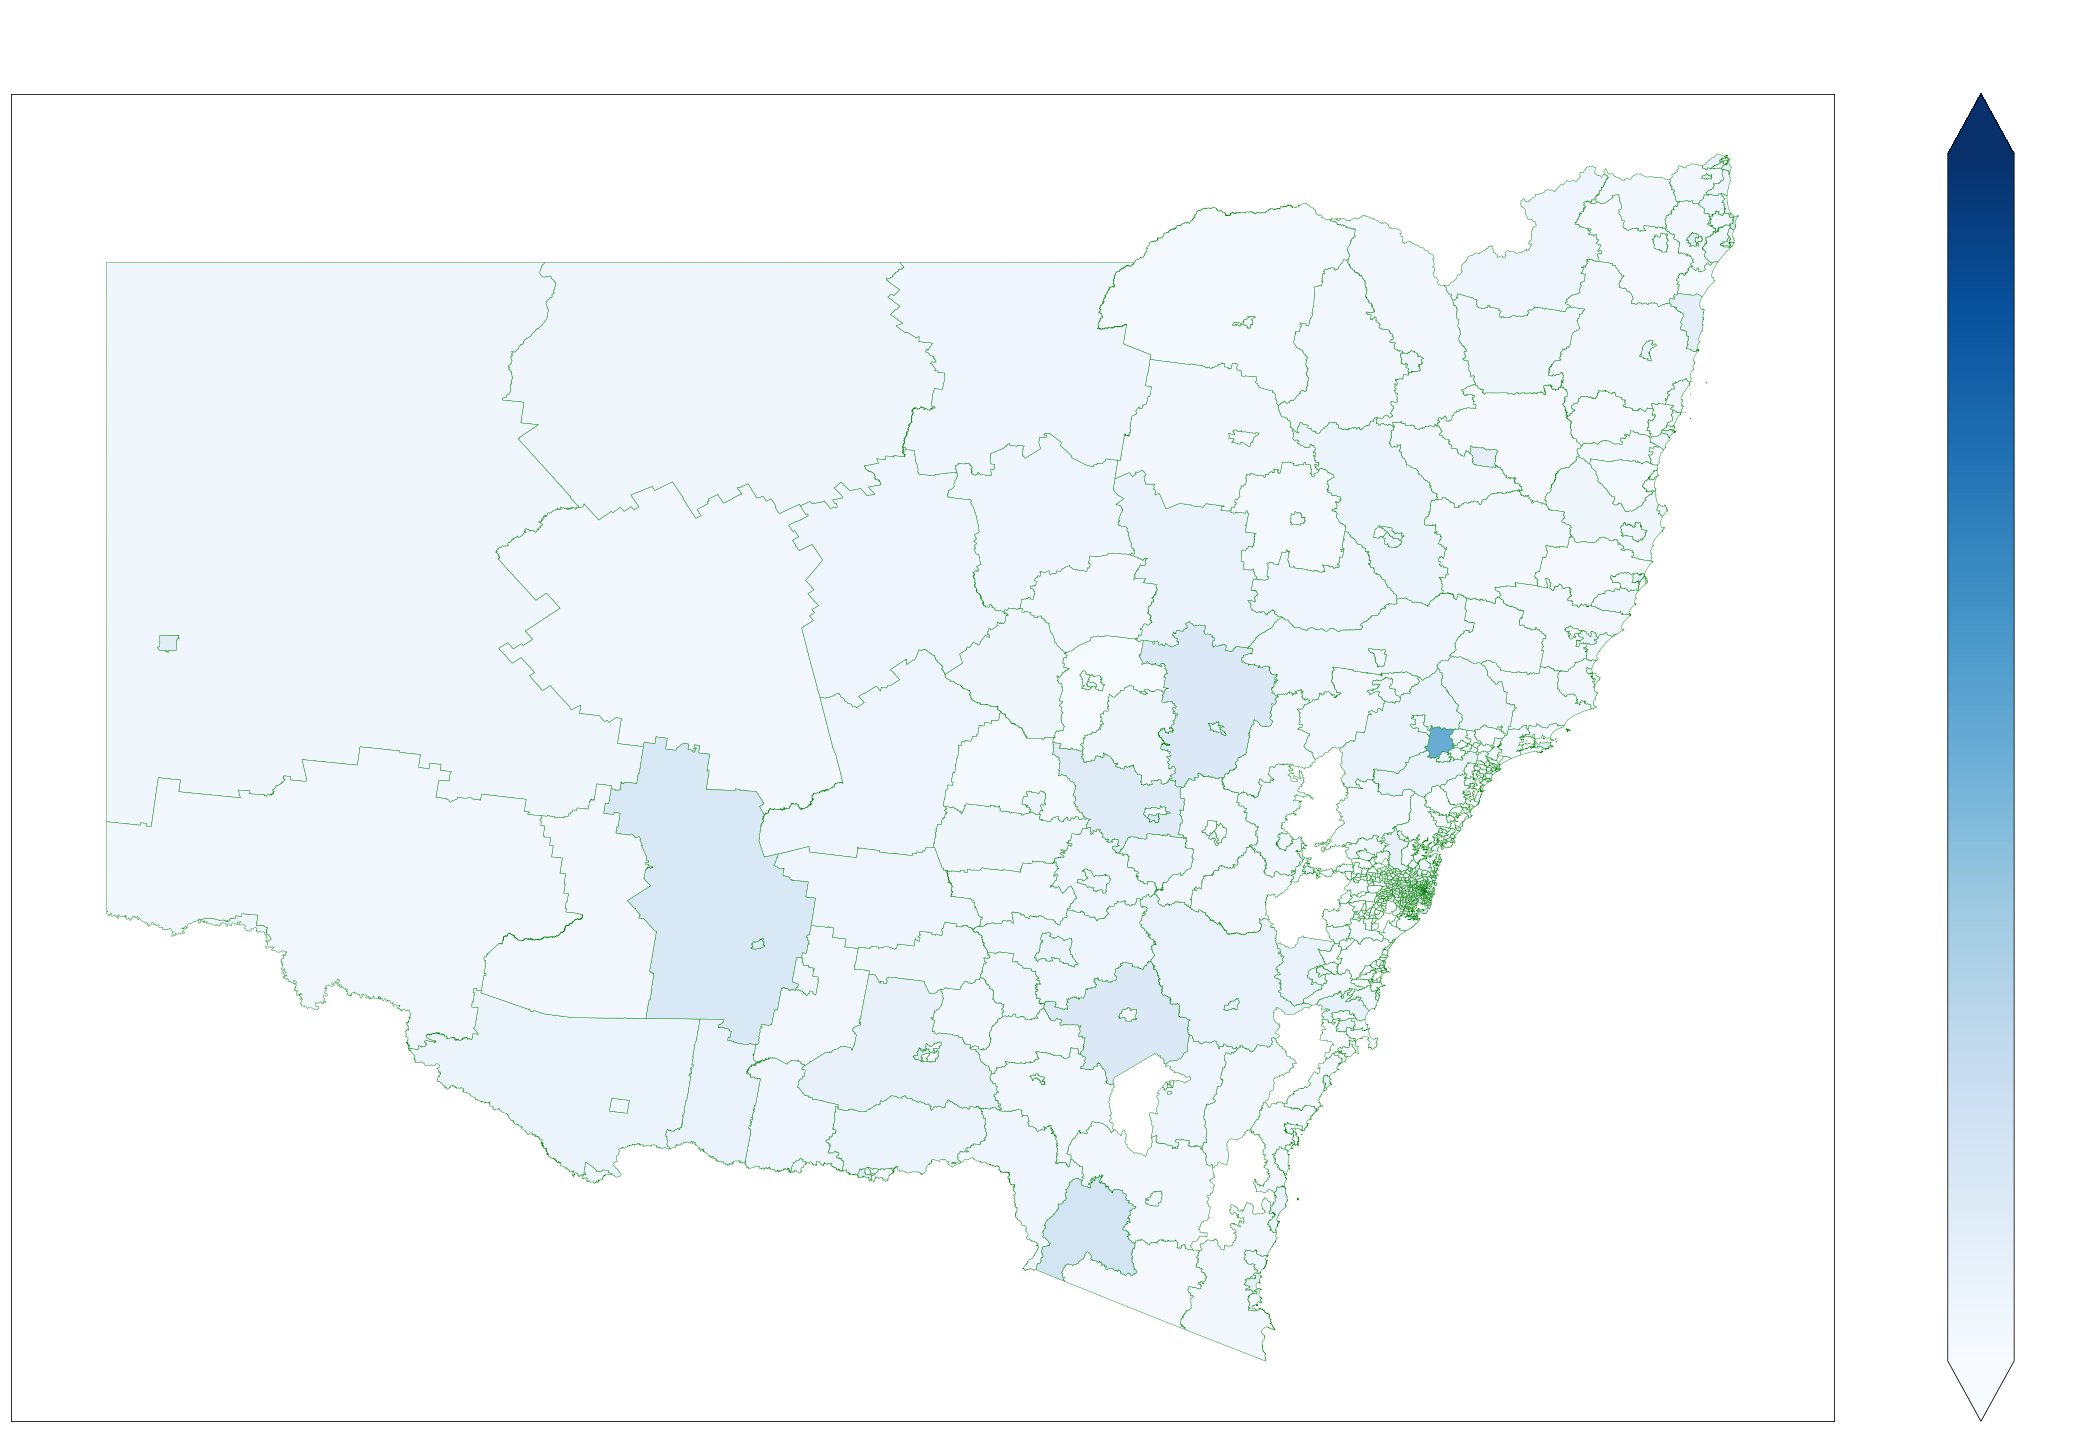

In [114]:
norm = colors.Normalize(vmin=gdf41[col].min(), vmax=gdf41[col].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='Blues')

fig, ax = plt.subplots(figsize=(32, 20), tight_layout=True)

gdf41.plot(ax=ax, column=col, cmap='Blues', edgecolor='green', linewidth=0.4, legend=False,
          missing_kwds={
                           'color': 'grey',
                           'edgecolor': 'red',
                           'hatch': '///',
                           'label': 'No data'
                       })

ax_cbar = fig.colorbar(cbar, ax=ax, location='right', extend='both')
ax_cbar.ax.tick_params(labelsize=30.0, labelcolor='w', colors='w', width=8.0, length=8.0)
ax.axis('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title(label='Geo-map of NSW: SA2\nCount of unique liquor licences', pad=10.0, fontdict={'color': 'w', 'fontsize': 40.0})
plt.show()

In [115]:
%%time
gdf42 = \
gdf3.loc[mask, ['Licence number', 'SA3_NAME21', 'geometry']] \
.dropna().dissolve(by='SA3_NAME21', aggfunc='nunique')

CPU times: total: 3min 57s
Wall time: 3min 57s


##### 2.7.4.3 Top ten SA3s by count of unique liquor licences

In [116]:
gdf42.sort_values(by=col, ascending=False).head(10)

,geometry,Licence number
SA3_NAME21,,
Sydney Inner City,"MULTIPOLYGON (((151.17169 -33.89501, 151.17182...",2470
Lower Hunter,"POLYGON ((151.47334 -32.60619, 151.47285 -32.6...",580
Eastern Suburbs - North,"MULTIPOLYGON (((151.21896 -33.88216, 151.21907...",513
Newcastle,"MULTIPOLYGON (((151.71738 -32.95334, 151.71714...",494
North Sydney - Mosman,"POLYGON ((151.19988 -33.82206, 151.19999 -33.8...",451
Gosford,"MULTIPOLYGON (((151.20556 -33.53201, 151.20588...",342
Chatswood - Lane Cove,"POLYGON ((151.14321 -33.81174, 151.14330 -33.8...",336
Wollongong,"POLYGON ((150.88160 -34.44112, 150.88126 -34.4...",327
Richmond Valley - Coastal,"MULTIPOLYGON (((153.40206 -28.99838, 153.40379...",305


##### 2.7.4.4 Plot -  count of unique liquor licences by **SA3** polygons

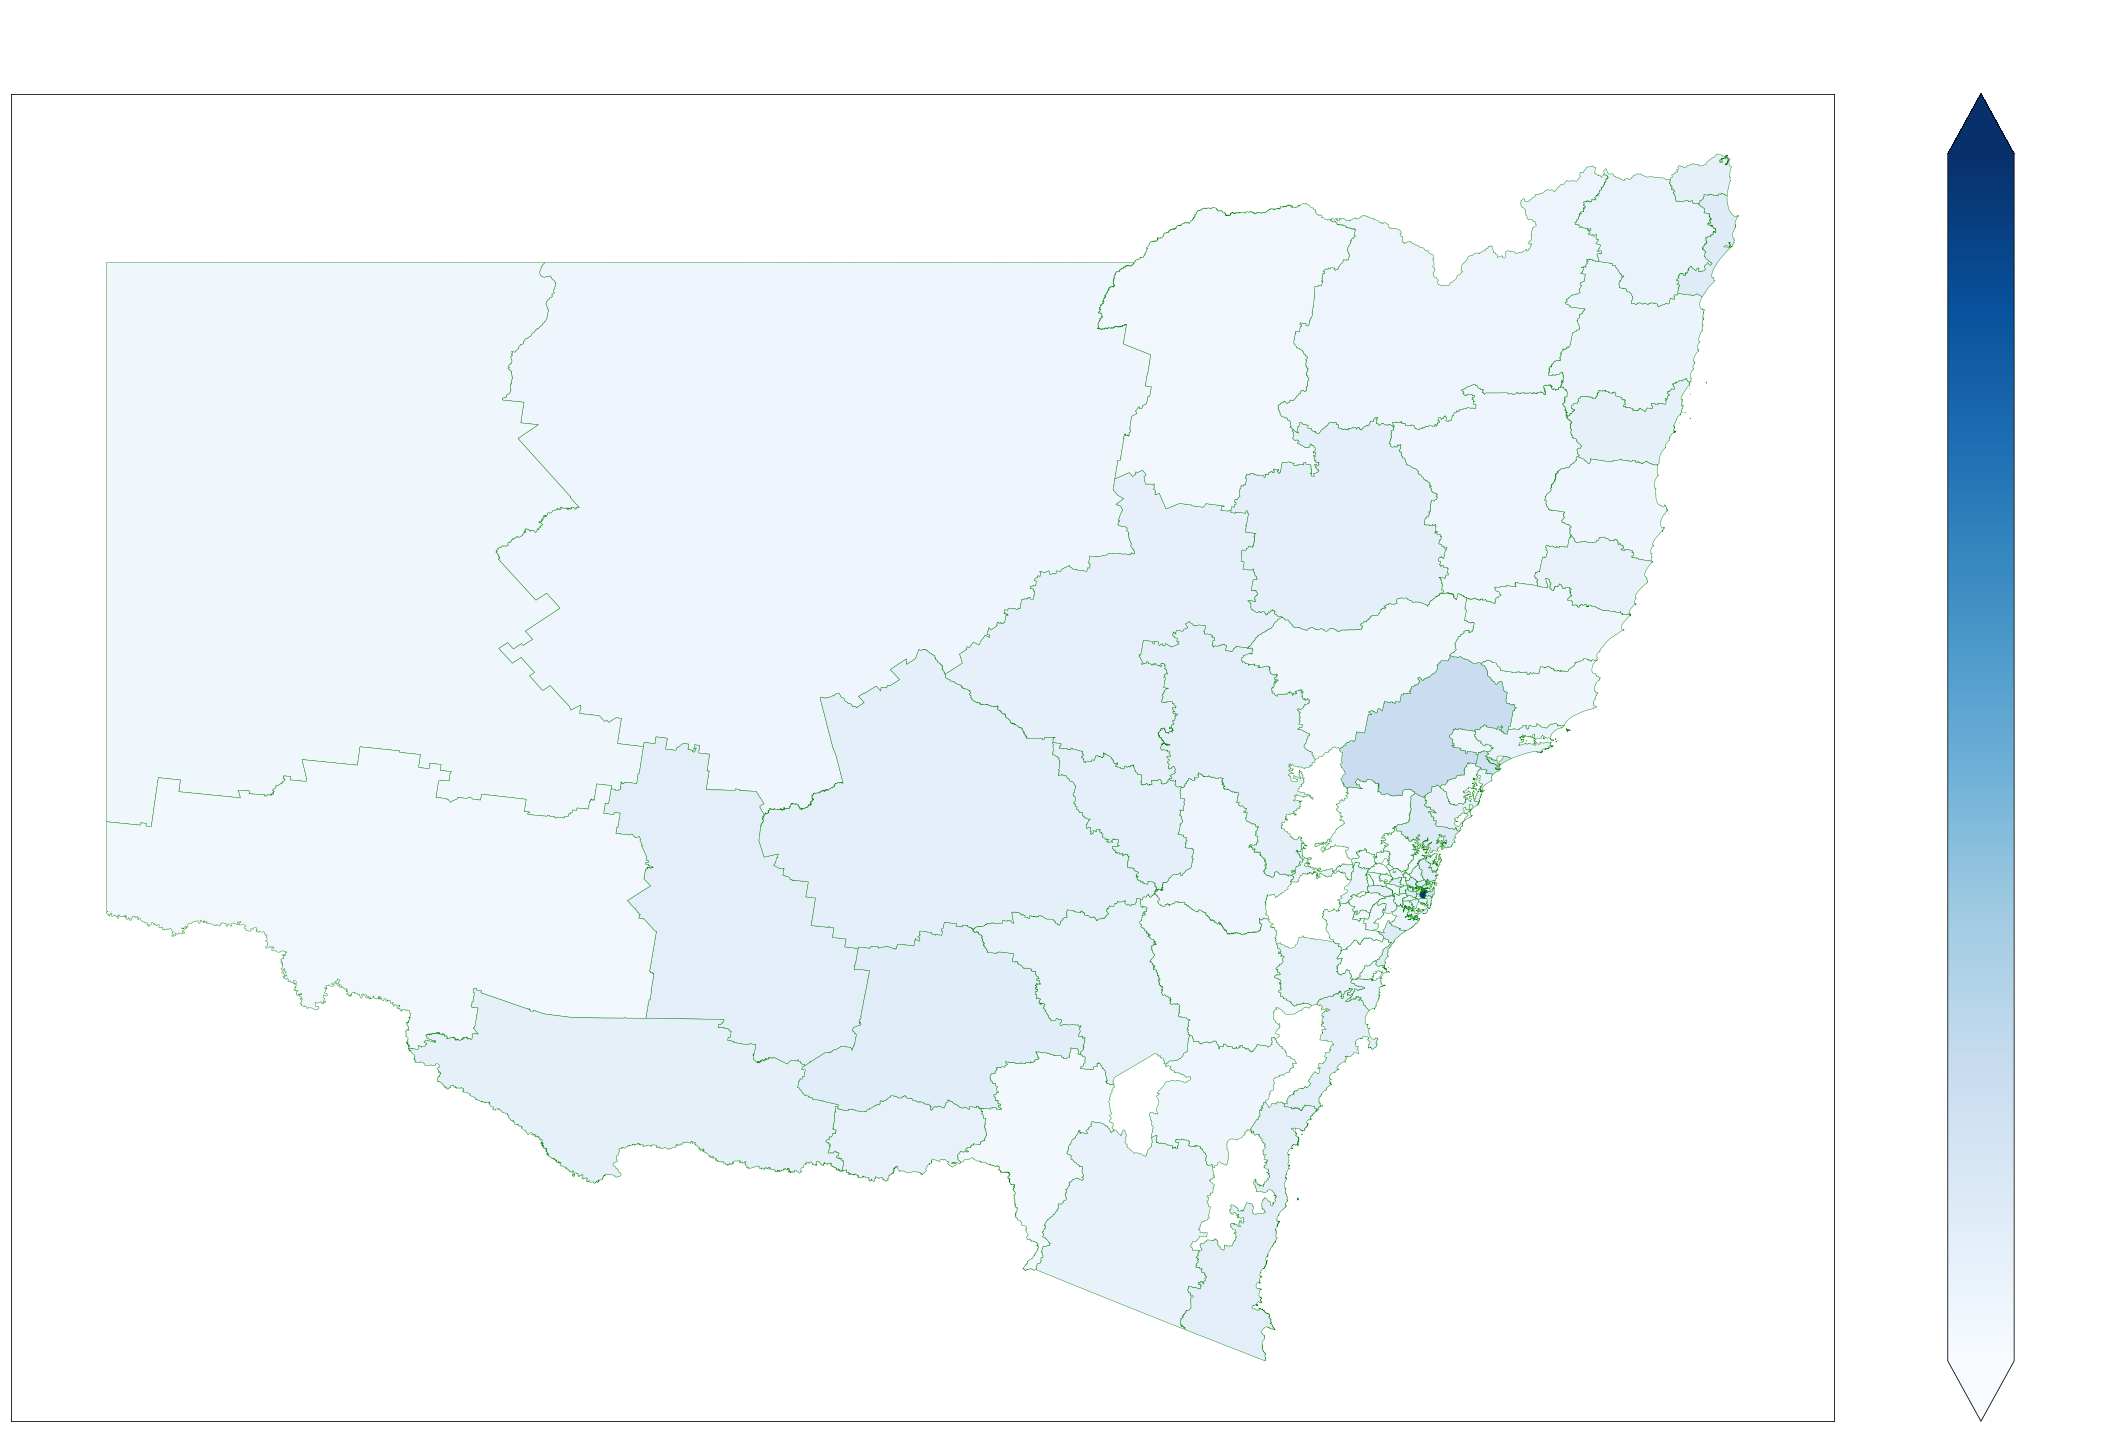

In [117]:
norm = colors.Normalize(vmin=gdf42[col].min(), vmax=gdf42[col].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='Blues')

fig, ax = plt.subplots(figsize=(32, 20), tight_layout=True)

gdf42.plot(ax=ax, column=col, cmap='Blues', edgecolor='green', linewidth=0.4, legend=False,
          missing_kwds={
                           'color': 'grey',
                           'edgecolor': 'red',
                           'hatch': '///',
                           'label': 'No data'
                       })

ax_cbar = fig.colorbar(cbar, ax=ax, location='right', extend='both')
ax_cbar.ax.tick_params(labelsize=30.0, labelcolor='w', colors='w', width=8.0, length=8.0)
ax.axis('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title(label='Geo-map of NSW: SA3\nCount of unique liquor licences', pad=10.0, fontdict={'color': 'w', 'fontsize': 40.0})
plt.show()

### 2.8 Answering assessment questions

#### 2.8.1 Question 1
What is the most common street name that has more than 10 letters?

In [118]:
re_pat1 = re.compile(r'[0-9]+?')
re_pat2 = re.compile(r'^C+?\w*?N+?\w*?R$')

In [119]:
def to_st_name(row):
    if isinstance(row, list):
        t0 = [str(e).strip().upper() for e in row]
        t1 = [str(e).strip().upper() for e in reversed(row)]
        t2 = None
        l = len(row)
        
        for i, elem in enumerate(t1):
            if elem.lower() == 'of':
                t1[i] = '9999'
                
        for i, elem in enumerate(t1):
            if elem == 'AND':
                t1[i] = '&' 
                
        for i, elem in enumerate(t0):
            if elem == 'AND':
                t0[i] = '&'
        
        for i, elem in enumerate(t1):
            # print(elem)
            if re_pat1.match(elem) or re_pat2.match(elem):
                t2 = t0[l-i:]
                # print(elem)
                if not t2:
                    return np.nan
                return t2
        return t0
    return row

In [120]:
s1 = df1['Address'].str.split(' ').apply(to_st_name)

In [121]:
s1.head()

0       [BARKER, AVE]
1    [BURKINSHAW, ST]
2         [RIVER, ST]
3         [BEACH, ST]
4     [HUMPHRIES, RD]
Name: Address, dtype: object

In [122]:
s1.apply(lambda x: x[-1] if isinstance(x,list) else x).value_counts().head(10)

ST        6919
RD        4376
STREET    1048
AVE        747
HWY        657
ROAD       655
DR         567
PDE        289
STS        261
AVENUE     198
Name: Address, dtype: int64

In [123]:
df1.loc[(~df1['Address'].isna()) & (s1.isna()), 'Address'].count()

197

<span style="color:red">197 invalid addresses (i.e. non-null or invalid)</span>

Mapping of road type name to road type abbreviations (i.e. road code) is obtained from:
- [Person (address)—street type, code A[AAA]](https://meteor.aihw.gov.au/content/270020)
- [Address—road type, code AA[AA]](https://meteor.aihw.gov.au/content/429840)

In [124]:
st_types = {st_type: addr for st_type, addr in pd.read_csv('street_types.csv').values}

In [125]:
st_types

{'ACCESS': 'ACCS',
 'ALLEY': 'ALLY',
 'ALLEYWAY': 'ALWY',
 'AMBLE': 'AMBL',
 'APPROACH': 'APP',
 'ARCADE': 'ARC',
 'ARTERIAL': 'ARTL',
 'ARTERY': 'ARTY',
 'AVENUE': 'AVE',
 'BANAN': 'BA',
 'BEND': 'BEND',
 'BOARDWALK': 'BWLK',
 'BOULEVARD': 'BVD',
 'BOULEVARDE': 'BVD',
 'BRACE': 'BR',
 'BRAE': 'BRAE',
 'BREAK': 'BRK',
 'BROW': 'BROW',
 'BYPASS': 'BYPA',
 'BYWAY': 'BYWY',
 'CAUSEWAY': 'CSWY',
 'CENTRE': 'CTR',
 'CHASE': 'CH',
 'CIRCLE': 'CIR',
 'CIRCUIT': 'CCT',
 'CIRCUS': 'CRCS',
 'CLOSE': 'CL',
 'CONCOURSE': 'CON',
 'COPSE': 'CPS',
 'CORNER': 'CNR',
 'COURT': 'CT',
 'COURTYARD': 'CTYD',
 'COVE': 'COVE',
 'CRESCENT': 'CR',
 'CREST': 'CRST',
 'CROSS': 'CRSS',
 'CUL-DE-SAC': 'CSAC',
 'CUTTING': 'CUTT',
 'DALE': 'DALE',
 'DIP': 'DIP',
 'DRIVE': 'DR',
 'DRIVEWAY': 'DVWY',
 'EDGE': 'EDGE',
 'ELBOW': 'ELB',
 'END': 'END',
 'ENTRANCE': 'ENT',
 'ESPLANADE': 'ESP',
 'EXPRESSWAY': 'EXP',
 'FAIRWAY': 'FAWY',
 'FOLLOW': 'FOLW',
 'FOOTWAY': 'FTWY',
 'FORMATION': 'FORM',
 'FREEWAY': 'FWY',
 'FRONTAG

In [126]:
st_types_abbr = list(set(st_types.values()))
st_types_name = list(set(st_types.keys()))

In [127]:
def rename_st_type(row):
    if isinstance(row, list):
        if row[-1] in st_types_name:
            t0 = row
            t0[-1] = st_types[row[-1]]
            return t0
        return row
    return row            

In [128]:
s1 = s1.apply(rename_st_type)

In [129]:
s1.apply(lambda x: x[-1] if isinstance(x,list) else x).value_counts().head(30)

ST            7974
RD            5031
AVE            945
HWY            747
DR             739
PDE            363
STS            275
PL             214
WAY            173
LANE           160
BVD            107
PARK            93
RDS             91
CTR             81
CRES            75
ESP             74
OVAL            61
CR              51
KINGSWAY        48
CCT             46
CL              41
AV              40
TCE             30
LN              27
STEYNE          26
BROADWAY        21
STRAND          21
VILLAGE         20
MALL            19
RACECOURSE      19
Name: Address, dtype: int64

In [130]:
def sep_multi_streets(row):
    if isinstance(row, list):
        d = {
            'STS': 'ST',
            'RDS': 'RD',
            'HWYS': 'HWY',
            'AVES': 'AVES',
            'DRS': 'DR'
        }
        t0 = pd.Series(row).drop_duplicates().to_list()
        t1 = None
        t2 = None
        st_type = None
        if row[-1] in d.keys() and '&' in row:
            st_type = d[row[-1]]
            t0.remove(row[-1])
            for i, elem in enumerate(row):
                if elem == '&':
                    t1 = t0[:i]
                    t2 = t0[i+1:]
                    t1.append(st_type)
                    t2.append(st_type)
                    t1 = pd.Series(t1).drop_duplicates().to_list()
                    t2 = pd.Series(t2).drop_duplicates().to_list()
                    return [t1, t2]
            return [t0]
        return [t0]
    return row

In [131]:
s1 = s1.apply(sep_multi_streets).explode()

In [132]:
s1.head(20)

0           [BARKER, AVE]
1        [BURKINSHAW, ST]
2             [RIVER, ST]
3             [BEACH, ST]
4         [HUMPHRIES, RD]
5          [STANMORE, RD]
6           [DOROTHY, ST]
7            [PRINCE, ST]
7            [DURHAM, ST]
8             [THE, FAWY]
9             [SHORT, ST]
10    [CAPTAIN, COOK, DR]
11        [FORRESTER, RD]
11          [BORONIA, RD]
12        [MELBOURNE, ST]
13             [RUTH, PL]
14        [RIVERSIDE, DR]
15        [BLACKWALL, RD]
16    [YARRABANDINNI, RD]
17         [QUEENBAR, RD]
Name: Address, dtype: object

In [133]:
def q1(row):
    if isinstance(row, list):
        t0 = None
        if row[-1] in st_types_abbr and len(row) > 1:
            t0 = row[:-1]
            if len(t0) > 1:
                return len(''.join(t0))
            return len(row[0])
         
        if len(row) > 1:
            return len(''.join(row))
        return len(row[0])
    return 0

In [134]:
s2 = s1.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

##### 2.8.1.1 Answer

In [135]:
s2[(s1.apply(q1) > 10)].value_counts().head(20).to_frame(name='Most common street name that has more than 10 letters')

,Most common street name that has more than 10 letters
GREAT WESTERN HWY,56
THE ENTRANCE RD,40
OLD NORTHERN RD,39
CASTLEREAGH ST,36
DARLINGHURST RD,34
NEW SOUTH HEAD RD,33
MARRICKVILLE RD,30
LAWRENCE HARGRAVE DR,29
CAMDEN VALLEY WAY,27
KING GEORGES RD,22


#### 2.8.2 Question 2
Which Month of the year had the second most start dates?

In [136]:
df2 = df1.loc[~df1['Start date'].isna(), ['Start date']].copy()

In [137]:
df2 = df2.assign(yr_mth=lambda df: df['Start date'].dt.year.mul(100).add(df['Start date'].dt.month)) \
         .drop_duplicates()

In [138]:
df2['yr_mth'].value_counts().head(10)

200905    25
201609    24
202007    23
200907    23
201008    23
201104    22
201307    22
200903    22
200904    22
201907    22
Name: yr_mth, dtype: int64

##### 2.8.2.1 Answer

<span style="color:red">September of 2016 had the second most start dates</span>

#### 2.8.3 Question 3
Which year had the largest increase year on year (percentage wise)?

In [139]:
df1[['Start date', 'Licence number']] \
.dropna(subset=['Start date'], how='all') \
.assign(year=lambda df: df['Start date'].dt.year) \
.pipe(lambda df: df.groupby(['year'], as_index=False)[['Licence number']].nunique()) \
.sort_values(by='year') \
.reset_index(drop=True) \
.rename(columns={'Licence number': 'count'}) \
.pipe(lambda df: pd.Series(range(df.year.min(), df.year.max(), 1)).to_frame(name='year').merge( \
                    df, how='left', left_on='year', right_on='year'
                 )) \
.assign(pct_change_yoy=lambda df: df['count'].pct_change(1).mul(100).round(2)) \
.fillna(0) \
.sort_values(by=['pct_change_yoy', 'count'], ascending=False) \
.head(10)

,year,count,pct_change_yoy
18,1923,101.0,3266.67
15,1920,5.0,400.00
42,1947,206.0,390.48
50,1955,385.0,253.21
41,1946,42.0,223.08
25,1930,11.0,175.00
37,1942,11.0,120.00
29,1934,8.0,100.00
20,1925,4.0,100.00
24,1929,4.0,100.00


##### 2.8.3.1 Answer

<span style="color:red">Year of 1923 had the largest increase year on year (percentage wise)</span>

### 2.9 Creating dashboard data and ingesting them to Bigquery

#### 2.9.1 Creating data for page one of dashboard

In [140]:
df2 = pd.DataFrame(gdf3).drop(columns='geometry')

In [141]:
cols = to_cat_col_list + ['SA2_NAME21', 'SA3_NAME21']

In [142]:
cols.remove('Precinct')
cols.remove('Status')
cols.remove('Trading Status')

In [143]:
cols

['After3am',
 'Primary service',
 'Right to keep gaming',
 'Unrestricted',
 'After12am',
 'Extended trading',
 'Reduced trading',
 'After5am',
 'Band',
 'Licence type',
 'SA2_NAME21',
 'SA3_NAME21']

In [144]:
measures = {
    'Licence number': ['nunique', 'count', 'Other measures'],
    'GMEs': ['sum', 'sum', 'Other measures'],
    'EGMs': ['sum', 'sum', 'Other measures'],
    'Authorisation count': ['sum', 'sum', 'Other measures'],
    'Business type count': ['sum', 'sum', 'Other measures']
}

In [145]:
measures.update({c: ['sum', 'sum', 'Authentication measures'] for c in df1.columns if 'AUTH:' in c})
measures.update({c: ['sum', 'sum', 'Business type measures'] for c in df1.columns if 'BIZ:' in c})

In [146]:
measures

{'Licence number': ['nunique', 'count', 'Other measures'],
 'GMEs': ['sum', 'sum', 'Other measures'],
 'EGMs': ['sum', 'sum', 'Other measures'],
 'Authorisation count': ['sum', 'sum', 'Other measures'],
 'Business type count': ['sum', 'sum', 'Other measures'],
 'AUTH: Club functions authorisation': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH: Drink on premises authorisation micro-brewery': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH: Drink on-premises permanent authorisation': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH: Extended trading authorisation': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH: Junior members authorisation': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH: Minors area authorisation': ['sum', 'sum', 'Authentication measures'],
 'AUTH: Minors functions authorisation': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH: Multi-occasion extended trading authorisation': ['sum',
  'sum',
  'Authentication measures'],
 'AUTH:

In [147]:
df4 = pd.DataFrame()

for col in cols:
    for measure in measures.keys():
        # col = 'After3am'
        # measure = 'Licence number'

        df3 = df2.copy()
        df3 = df3[~df3[measure].isna()]

        df3 = \
            df3.assign(year=lambda df: df['Start date'].dt.year) \
            .assign(month=lambda df: df['Start date'].dt.month)

        df3[col] = df3[col].fillna('_NULL_').astype(str)
        print(f'-----{col}--{measure}---')
        pprint(df2[col].value_counts(dropna=False))

        df_temp = \
            df3[[col, measure, 'year', 'month', 'Status', 'Trading Status']] \
            .groupby([col, 'year', 'month', 'Status', 'Trading Status'], as_index=False)[[measure]].agg(measures[measure][0]) \
            .rename(columns={col: 'categories', measure: 'value'}) \
            .assign(variable=col) \
            .assign(temp=measure) \
            .assign(temp1=lambda df: df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)) \
            .assign(temp2=measures[measure][1]) \
            .assign(temp3=measures[measure][2]) \
            .rename(columns={'temp': 'measure', 'temp1': 'year month', 'temp2': 'aggegrate', 'temp3': 'measure type'}) \
        
        df4 = pd.concat([df4, df_temp], ignore_index=True)
        print()

-----After3am--Licence number---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--GMEs---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--EGMs---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--Authorisation count---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--Business type count---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--AUTH: Club functions authorisation---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--AUTH: Drink on premises authorisation micro-brewery---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--AUTH: Drink on-premises permanent authorisation---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--AUTH: Extended trading authorisation---
No     16194
Yes     2553
Name: After3am, dtype: int64

-----After3am--AUTH: Junior members authorisation---
No     16194
Yes     2553
Name: After3am, dt


-----Primary service--AUTH: Reduced trading hours---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--AUTH: Residents bar authorisation---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--AUTH: Right to keep gaming machines---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--AUTH: Sale on other premises authorisation---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--AUTH: Take away sales authorisation---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--AUTH: Unrestricted on premises hours---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--AUTH: Vessel trading authorisation---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--BIZ: Accommodation---
No     17079
Yes     1668
Name: Primary service, dtype: int64

-----Primary service--BIZ: 

-----Right to keep gaming--AUTH: Take away sales authorisation---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--AUTH: Unrestricted on premises hours---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--AUTH: Vessel trading authorisation---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--BIZ: Accommodation---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--BIZ: Adult relaxation entertainment facility---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--BIZ: Airport---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--BIZ: Art gallery---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----Right to keep gaming--BIZ: Bar---
No     15439
Yes     3308
Name: Right to keep gaming, dtype: int64

-----


-----Unrestricted--AUTH: Vessel trading authorisation---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Accommodation---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Adult relaxation entertainment facility---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Airport---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Art gallery---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Bar---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Bottle shop & Delivery---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Catering service---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Cinema public entertainment venue---
No     17508
Yes     1239
Name: Unrestricted, dtype: int64

-----Unrestricted--BIZ: Clothing T

-----After12am--BIZ: Co-shared Workspace---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Cooking school---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Delivery only---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Food and beverage outlet---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Food court---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Food hall---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Full hotel---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Furniture store---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: General bar---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Hairdressing salon---
No     15531
Yes     3216
Name: After12am, dtype: int64

-----After12am--BIZ: Health and beaut


-----Extended trading--BIZ: Karaoke venue---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Local product promotion---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Multi-function---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Music school---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Music venue---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Other public entertainment venue---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Pop-up Bar---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Pop-up Event---
No     16030
Yes     2717
Name: Extended trading, dtype: int64

-----Extended trading--BIZ: Public arena and events---
No     16030
Yes     2717
Name: Extended trading,

-----Reduced trading--BIZ: Pop-up Bar---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Pop-up Event---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Public arena and events---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Public hall---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Racing facility---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Restaurant---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Retail---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Retirement village---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--BIZ: Social activity and support---
No     10574
Yes     8173
Name: Reduced trading, dtype: int64

-----Reduced trading--

-----After5am--BIZ: Tour operator---
No     16924
Yes     1823
Name: After5am, dtype: int64

-----After5am--BIZ: Tourist and cultural precinct---
No     16924
Yes     1823
Name: After5am, dtype: int64

-----After5am--BIZ: Tourist facility---
No     16924
Yes     1823
Name: After5am, dtype: int64

-----After5am--BIZ: Vessel---
No     16924
Yes     1823
Name: After5am, dtype: int64

-----After5am--BIZ: Wine bar---
No     16924
Yes     1823
Name: After5am, dtype: int64

-----Band--Licence number---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--GMEs---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--EGMs---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--Authorisation count---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--Business type count---
0       1


-----Band--BIZ: Special event---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Sport facility---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Tertiary institution---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Theatre public entertainment venue---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Tour operator---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Tourist and cultural precinct---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Tourist facility---
0       15442
2        1308
1        1119
3         878
<NA>        0
Name: Band, dtype: Int64

-----Band--BIZ: Vessel---
0       15442
2       


-----Licence type--AUTH: Right to keep gaming machines---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor - hotel licence                  2127
Liquor - producer wholesaler licence    1771
Liquor - limited licence                1374
Liquor - club licence                   1286
Liquor - small bar licence               169
Liquor - pop-up licence                    2
Name: Licence type, dtype: int64

-----Licence type--AUTH: Sale on other premises authorisation---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor - hotel licence                  2127
Liquor - producer wholesaler licence    1771
Liquor - limited licence                1374
Liquor - club licence                   1286
Liquor - small bar licence               169
Liquor - pop-up licence                    2
Name: Licence type, dtype: int64

-----Licence type--AUTH: Take away sales authorisation---
Liquor - on-premises licence  


-----Licence type--BIZ: Food court---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor - hotel licence                  2127
Liquor - producer wholesaler licence    1771
Liquor - limited licence                1374
Liquor - club licence                   1286
Liquor - small bar licence               169
Liquor - pop-up licence                    2
Name: Licence type, dtype: int64

-----Licence type--BIZ: Food hall---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor - hotel licence                  2127
Liquor - producer wholesaler licence    1771
Liquor - limited licence                1374
Liquor - club licence                   1286
Liquor - small bar licence               169
Liquor - pop-up licence                    2
Name: Licence type, dtype: int64

-----Licence type--BIZ: Full hotel---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor -


-----Licence type--BIZ: Retail---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor - hotel licence                  2127
Liquor - producer wholesaler licence    1771
Liquor - limited licence                1374
Liquor - club licence                   1286
Liquor - small bar licence               169
Liquor - pop-up licence                    2
Name: Licence type, dtype: int64

-----Licence type--BIZ: Retirement village---
Liquor - on-premises licence            9152
Liquor - packaged liquor licence        2866
Liquor - hotel licence                  2127
Liquor - producer wholesaler licence    1771
Liquor - limited licence                1374
Liquor - club licence                   1286
Liquor - small bar licence               169
Liquor - pop-up licence                    2
Name: Licence type, dtype: int64

-----Licence type--BIZ: Social activity and support---
Liquor - on-premises licence            9152
Liquor - packaged liquor licenc


-----SA2_NAME21--AUTH: Drink on-premises permanent authorisation---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Length: 636, dtype: int64

-----SA2_NAME21--AUTH: Extended trading authorisation---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery              


-----SA2_NAME21--BIZ: Airport---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Length: 636, dtype: int64

-----SA2_NAME21--BIZ: Art gallery---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Length: 636, dtype: int64

---


-----SA2_NAME21--BIZ: Hairdressing salon---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Length: 636, dtype: int64

-----SA2_NAME21--BIZ: Health and beauty services---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Leng

Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Length: 636, dtype: int64

-----SA2_NAME21--BIZ: Sport facility---
Sydney (North) - Millers Point    661
Sydney (South) - Haymarket        374
NaN                               349
Branxton - Greta - Pokolbin       340
Surry Hills                       249
                                 ... 
Cecil Hills                         1
Richmond (SA)                       1
Melbourne CBD - West                1
Chullora                            1
Rookwood Cemetery                   1
Name: SA2_NAME21, Length: 636, dtype: int64

-----SA2_NAME21--BIZ: Tertiary ins

-----SA3_NAME21--AUTH: Extended trading authorisation---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--AUTH: Junior members authorisation---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3


-----SA3_NAME21--BIZ: Art gallery---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--BIZ: Bar---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--BIZ: Bottle shop & Delivery---
Sydne


-----SA3_NAME21--BIZ: Karaoke venue---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--BIZ: Local product promotion---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--BIZ: Multi-fun


-----SA3_NAME21--BIZ: Theatre public entertainment venue---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--BIZ: Tour operator---
Sydney Inner City              2472
Lower Hunter                    584
Eastern Suburbs - North         513
Newcastle                       494
North Sydney - Mosman           451
                               ... 
Illawarra Catchment Reserve       2
Moira                             1
Murray River - Swan Hill          1
West Torrens                      1
Melbourne City                    1
Name: SA3_NAME21, Length: 96, dtype: int64

-----SA3_NAME21--BIZ

In [148]:
df4 = df4.sort_values(by=['measure type', 'variable', 'categories', 'Status', 'Trading Status', 'year', 'month'])

In [149]:
df4.sample(5)

,categories,year,month,Status,Trading Status,value,variable,measure,year month,aggegrate,measure type
20339,No,1946,2,Current,Trading,0,After3am,AUTH: Minors area authorisation,1946-02,sum,Authentication measures
861807,No,1961,9,Current,Trading,0,Reduced trading,BIZ: Delivery only,1961-09,sum,Business type measures
3070938,Inverell - Tenterfield,1961,10,Current,Trading,0,SA3_NAME21,BIZ: Food hall,1961-10,sum,Business type measures
946335,No,1947,4,Current,Temporarily Ceased Trading,1,After5am,AUTH: Minors area authorisation,1947-04,sum,Authentication measures
2332265,Maclean - Yamba - Iluka,1984,10,Current,Trading,0,SA2_NAME21,BIZ: Public hall,1984-10,sum,Business type measures


#### 2.9.2 Ingesting data for page one of dashboard to Bigquery

In [150]:
from google.oauth2 import service_account
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload
import tempfile
import time
import pytz
from datetime import datetime, timedelta

In [151]:
scopes = ['https://www.googleapis.com/auth/bigquery', 
          'https://www.googleapis.com/auth/devstorage.full_control']

In [152]:
project_id = 'quickstart-1600678002353'
temp_dir = tempfile.gettempdir()

In [153]:
def service_account_authenticate():
    json_dict = \
    {
    "type": "service_account",
    "project_id": f"{project_id}",
    "private_key_id": os.environ['GCP_SERVICE_ACCOUNT_KEY_ID_CLIENT_ID'].split('|')[0],
    "private_key": os.environ['GCP_SERVICE_ACCOUNT_PRIVATE_KEY'].replace(r'\n', '\n'),
    "client_email": "shaun-wang-dev-service-account@quickstart-1600678002353.iam.gserviceaccount.com",
    "client_id": os.environ['GCP_SERVICE_ACCOUNT_KEY_ID_CLIENT_ID'].split('|')[1],
    "auth_uri": "https://accounts.google.com/o/oauth2/auth",
    "token_uri": "https://oauth2.googleapis.com/token",
    "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
    "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/shaun-wang-dev-service-account%40quickstart-1600678002353.iam.gserviceaccount.com"
    }
    credentials = service_account.Credentials.from_service_account_info(info=json_dict, scopes=scopes)

    return credentials

In [154]:
def api_points():
    credentials = service_account_authenticate()
    
    bigquery_api = build('bigquery', 'v2', credentials=credentials)
    bigquery_transfer_api = build('bigquerydatatransfer', 'v1', credentials=credentials)
    cloud_storage_api = build('storage', 'v1', credentials=credentials)

    return bigquery_api, bigquery_transfer_api, cloud_storage_api

In [155]:
def upload_csv_to_bucket(csv_file_name, df, chunk_size=256*1024*80):
    # hardcoding bucket_name for this assessment only
    bucket_name = 'bigquery_data_csv_staging_bucket_shaun_wang'

    _,_,cloud_storage_api = api_points()
    
    request = cloud_storage_api.objects().list(bucket=bucket_name)
    response = request.execute(num_retries=3)

    bucket_is_empty = False

    if 'items' not in response.keys():
        bucket_is_empty = True
        print(f'bucket {bucket_name} is empty!')
    if not bucket_is_empty:
        files = [item['name'] for item in response['items']]
        if csv_file_name in files:
            request = cloud_storage_api.objects().delete(bucket=bucket_name, 
                                                        object=csv_file_name)
            response = request.execute(num_retries=3)
            if response:
                print('Cloud storage API objects.list() error!')
                raise RuntimeError
            else:
                print(f'{csv_file_name} deleted from bucket {bucket_name}')
        else:
            print(f'{csv_file_name} is not found in bucket {bucket_name}')
    
    data_file_path = os.path.join(temp_dir, csv_file_name)
    df.to_csv(data_file_path, index=False)
    total_size = os.path.getsize(data_file_path)
    print(f'Total upload size is {total_size/1024/1024:.4f} megabytes')
    print(f'Chunk size is {chunk_size/1024/1024:.2f} megabytes')

    request_body = \
        {'name': csv_file_name, 'uploadType': 'resumable'}
    
    media = MediaFileUpload(data_file_path, 
                            chunksize=chunk_size, 
                            mimetype='application/vnd.ms-excel', 
                            resumable=True)

    request = cloud_storage_api.objects().insert(bucket=bucket_name, 
                                                 body=request_body,
                                                 media_body=media)
    response = None
    while response is None:
        status, response = request.next_chunk(num_retries=3)
        if status:
            print(f'Uploaded {status.progress():.1%}')
    if int(response['size']) == total_size:
        print('File uploaded!')
    else:
        print('Upload failed!')
        raise RuntimeError

    return None

In [156]:
upload_csv_to_bucket('assessment_data', df4)

assessment_data deleted from bucket bigquery_data_csv_staging_bucket_shaun_wang
Total upload size is 376.1620 megabytes
Chunk size is 20.00 megabytes
Uploaded 5.3%
Uploaded 10.6%
Uploaded 16.0%
Uploaded 21.3%
Uploaded 26.6%
Uploaded 31.9%
Uploaded 37.2%
Uploaded 42.5%
Uploaded 47.9%
Uploaded 53.2%
Uploaded 58.5%
Uploaded 63.8%
Uploaded 69.1%
Uploaded 74.4%
Uploaded 79.8%
Uploaded 85.1%
Uploaded 90.4%
Uploaded 95.7%
File uploaded!


In [157]:
dataset_id = 'assessment'
table_id = 'assessment_data'

In [158]:
def check_bq_table(table_id, dataset_id):
    bigquery_api, _, _ = api_points()

    request = bigquery_api.tables().list(projectId=project_id, 
                                         datasetId=dataset_id)

    response = request.execute(num_retries=3)

    if 'tables' in response.keys():
        table_names = [table['tableReference']['tableId'] for table in response['tables']]

        if table_id in table_names:
            for i in range(10):
                request = bigquery_api.tables().delete(projectId=project_id, 
                                                       datasetId=dataset_id, 
                                                       tableId=table_id)
                response = request.execute(num_retries=3)
                if response=='':
                    print(f'{table_id} has been deleted from {dataset_id}')
                    break
            else:
                print('Deletion failed!')
                raise ValueError
        else:
            print(f'{table_id} is NOT in {dataset_id}')
    else:
        print(f'dataset {dataset_id} is empty')
        
    return None

In [159]:
check_bq_table(table_id, dataset_id)

assessment_data has been deleted from assessment


In [160]:
type_dict = {
    'b': 'BOOLEAN',
    'i': 'INTEGER',
    'f': 'FLOAT',
    'O': 'STRING',
    'S': 'STRING',
    'U': 'STRING',
    'M': 'DATETIME'
}

In [161]:
df4.columns = [col.lower().replace(' ', '_') for col in df4.columns]

In [162]:
fields = [{'name': col, 'type': type_dict[dtype.kind], 'mode': 'NULLABLE'} for dtype, col in zip(df4.dtypes, df4.columns)]

In [163]:
fields

[{'name': 'categories', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'year', 'type': 'INTEGER', 'mode': 'NULLABLE'},
 {'name': 'month', 'type': 'INTEGER', 'mode': 'NULLABLE'},
 {'name': 'status', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'trading_status', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'value', 'type': 'INTEGER', 'mode': 'NULLABLE'},
 {'name': 'variable', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'measure', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'year_month', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'aggegrate', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'measure_type', 'type': 'STRING', 'mode': 'NULLABLE'}]

In [164]:
df4 = df4.astype(str)

In [165]:
df4 = df4.replace({'<NA>': '', 'nan': '', 'NaN': '', 'NaT': ''})

In [166]:
table_reference = \
{
    'projectId': project_id,
    'datasetId': dataset_id,
    'tableId': table_id
}

In [167]:
table_resource = \
{
    'kind': 'bigquery#table',
    'id': f'{project_id}:{dataset_id}.{table_id}',
    'tableReference': table_reference,
    'description': 'Table created by using Python',
    'schema': {
        'fields': fields
    }
}

In [169]:
bigquery_api, _, _ = api_points()

In [170]:
request = bigquery_api.tables().insert(projectId=project_id, 
                                       datasetId=dataset_id,
                                       body=table_resource)
response = request.execute(num_retries=3)

In [171]:
def run_bigquery_transfer(config_id):
    _, bigquery_transfer_api, _ = api_points()
    config_name = f'projects/{project_id}/transferConfigs/{config_id}'
    utc_now_plus_5 = datetime.utcnow()+timedelta(seconds=5)
    utc_now_plus_5_string = \
    utc_now_plus_5.replace(tzinfo=pytz.UTC).isoformat()
    
    request_body = {'requestedRunTime': utc_now_plus_5_string}

    request = \
        bigquery_transfer_api.projects().transferConfigs() \
        .startManualRuns(parent=config_name, body=request_body)
    response = request.execute(num_retries=3)

    run_id = re.findall(r'runs/(.+)', response['runs'][0]['name'])[0]
    run_name = f'projects/{project_id}/transferConfigs/{config_id}/runs/{run_id}' 

    run_state = 'RUNNING'
    i = 1
    max_checks = 30
    while run_state != 'SUCCEEDED':
        request = \
            bigquery_transfer_api.projects().transferConfigs() \
            .runs().get(name=run_name)
        response = request.execute(num_retries=3)
        run_state = response['state']
        if run_state == 'FAILED' or i > max_checks or run_state == 'SUCCEEDED':
            break
        print(f'Check run state attempt {i:>3}: {run_state}')
        i += 1
        time.sleep(5)
    if run_state == 'SUCCEEDED':
        print('BigQuery transfer completed!')
    elif run_state == 'FAILED':
        print('BigQuery transfer failed!')
        raise RuntimeError
    elif i > max_checks:
        print('BigQuery transfer took too long!')
        raise RuntimeError
    else:
        print('BigQuery transfer failed!')
        raise RuntimeError

    return None

In [172]:
config_id = '62d7d221-0000-2e1a-9c60-f4f5e806a2e8'

In [173]:
run_bigquery_transfer(config_id)

Check run state attempt   1: RUNNING
Check run state attempt   2: RUNNING
Check run state attempt   3: RUNNING
Check run state attempt   4: RUNNING
Check run state attempt   5: RUNNING
Check run state attempt   6: RUNNING
Check run state attempt   7: RUNNING
Check run state attempt   8: RUNNING
Check run state attempt   9: RUNNING
Check run state attempt  10: RUNNING
Check run state attempt  11: RUNNING
Check run state attempt  12: RUNNING
BigQuery transfer completed!


#### 2.9.3 Creating data for page two of dashboard

In [174]:
gdf5 = gdf3.copy()

In [176]:
%%time
gdf5_points = gdf5.to_crs('+proj=cea').centroid.to_crs(gdf5.crs)

CPU times: total: 46.3 s
Wall time: 46.4 s


In [177]:
gdf5['geometry'] = gdf5_points

In [178]:
gdf6 = \
    gdf5[['Start date','Licence number', 'Status', 'Trading Status', 'SA2_NAME21', 'geometry']] \
    .assign(year=lambda df: df['Start date'].dt.year) \
    .assign(month=lambda df: df['Start date'].dt.month) \
    .assign(temp1=lambda df: df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)) \
    .rename(columns={'temp1': 'year month'}) \
    .drop(columns='Start date')

In [179]:
gdf6.head()

,Licence number,Status,Trading Status,SA2_NAME21,geometry,year,month,year month
0,LIQC300200019,Current,Trading,Glendale - Cardiff - Hillsborough,POINT (151.65986 -32.94227),1981,5,1981-05
1,LIQC300200035,Current,Trading,Tocumwal - Finley - Jerilderie,POINT (145.74451 -35.45275),1981,8,1981-08
2,LIQC300200078,Current,Trading,Maclean - Yamba - Iluka,POINT (153.26624 -29.42034),1981,12,1981-12
3,LIQC300200086,Current,Trading,Tuncurry,POINT (152.48562 -32.16065),1981,12,1981-12
4,LIQC300200094,Current,Trading,St Johns Park - Wakeley,POINT (150.90541 -33.87901),1982,3,1982-03


#### 2.9.4 Ingesting data for page two of dashboard to Bigquery

In [180]:
upload_csv_to_bucket('assessment_data_geo', gdf6)

assessment_data_geo deleted from bucket bigquery_data_csv_staging_bucket_shaun_wang
Total upload size is 1.9860 megabytes
Chunk size is 20.00 megabytes
File uploaded!


In [181]:
table_id = 'assessment_data_geo'

In [182]:
check_bq_table(table_id, dataset_id)

assessment_data_geo has been deleted from assessment


In [183]:
gdf6.columns = [col.lower().replace(' ', '_') for col in gdf6.columns]

In [184]:
fields = [{'name': col, 'type': type_dict[dtype.kind], 'mode': 'NULLABLE'} for dtype, col in zip(gdf6.dtypes, gdf6.columns)]

In [185]:
for i, dtype in enumerate(gdf6.dtypes):
    if str(dtype) == 'geometry':
        fields[i]['type'] = 'GEOGRAPHY'

In [186]:
fields

[{'name': 'licence_number', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'status', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'trading_status', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'sa2_name21', 'type': 'STRING', 'mode': 'NULLABLE'},
 {'name': 'geometry', 'type': 'GEOGRAPHY', 'mode': 'NULLABLE'},
 {'name': 'year', 'type': 'INTEGER', 'mode': 'NULLABLE'},
 {'name': 'month', 'type': 'INTEGER', 'mode': 'NULLABLE'},
 {'name': 'year_month', 'type': 'STRING', 'mode': 'NULLABLE'}]

In [187]:
gdf6 = gdf6.astype(str)

In [188]:
gdf6 = gdf6.replace({'<NA>': '', 'nan': '', 'NaN': '', 'NaT': ''})

In [189]:
table_reference = \
{
    'projectId': project_id,
    'datasetId': dataset_id,
    'tableId': table_id
}

In [190]:
table_resource = \
{
    'kind': 'bigquery#table',
    'id': f'{project_id}:{dataset_id}.{table_id}',
    'tableReference': table_reference,
    'description': 'Table created by using Python',
    'schema': {
        'fields': fields
    }
}

In [191]:
request = bigquery_api.tables().insert(projectId=project_id, 
                                       datasetId=dataset_id,
                                       body=table_resource)
response = request.execute(num_retries=3)

In [192]:
config_id = '62c5d833-0000-29ce-908e-f403045fefb6'

In [193]:
run_bigquery_transfer(config_id)

Check run state attempt   1: RUNNING
Check run state attempt   2: RUNNING
Check run state attempt   3: RUNNING
Check run state attempt   4: RUNNING
Check run state attempt   5: RUNNING
Check run state attempt   6: RUNNING
Check run state attempt   7: RUNNING
Check run state attempt   8: RUNNING
Check run state attempt   9: RUNNING
Check run state attempt  10: RUNNING
Check run state attempt  11: RUNNING
Check run state attempt  12: RUNNING
BigQuery transfer completed!
